# Berke Lab Spike Sorting and Decoding 

In [1]:
import datajoint as dj
import numpy as np
import matplotlib.pyplot as plt
from pynwb import NWBHDF5IO

import spyglass.common as sgc
import spyglass.spikesorting.v1 as sgs
import spyglass.position as sgp
from spyglass.common import Nwbfile
from spyglass.utils.nwb_helper_fn import get_nwb_file

# Make sure the session exists
#nwb_file_name = "IM-1594_20230726_.nwb"
nwb_file_name =  "IM-1478_20220720_.nwb"

# Fetch file create date and source version to make sure it's up to date
nwb_file_abspath = Nwbfile.get_abs_path(nwb_file_name)
nwbf = get_nwb_file(nwb_file_abspath)
print(f"File created on {nwbf.file_create_date[0].strftime('%m/%d/%Y %H:%M:%S')}")
print(f"Source script version {nwbf.source_script}")

/home/scrater/miniforge3/envs/spyglass/lib/python3.10/site-packages/datajoint/plugin.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[2025-12-11 11:48:23,195][INFO]: DataJoint 0.14.6 connected to scrater@lmf-db.cin.ucsf.edu:3306


File created on 12/05/2025 17:10:15
Source script version jdb_to_nwb 2.1.2.dev2+g12a9b6eed.d20251030


In [2]:
import jax

device_id = 6 # or whatever number GPU you want

device = jax.devices()[device_id]
jax.config.update("jax_default_device", device)

# or, check default device again
print("Default device setting:", jax.default_backend())
print("Explicit device you picked:", device)

Default device setting: gpu
Explicit device you picked: gpu:6


2025-12-11 11:48:53.907498: W external/org_tensorflow/tensorflow/compiler/xla/pjrt/gpu/gpu_helpers.cc:63] Unable to enable peer access between GPUs 0 and 9; status: INTERNAL: failed to enable peer access from 0x7f9be8b15be0 to 0x7f9bf88fb1b0: CUDA_ERROR_TOO_MANY_PEERS: peer mapping resources exhausted
2025-12-11 11:48:53.909903: W external/org_tensorflow/tensorflow/compiler/xla/pjrt/gpu/gpu_helpers.cc:63] Unable to enable peer access between GPUs 1 and 9; status: INTERNAL: failed to enable peer access from 0x7f9be0974d30 to 0x7f9bf88fb1b0: CUDA_ERROR_TOO_MANY_PEERS: peer mapping resources exhausted
2025-12-11 11:48:53.911937: W external/org_tensorflow/tensorflow/compiler/xla/pjrt/gpu/gpu_helpers.cc:63] Unable to enable peer access between GPUs 2 and 9; status: INTERNAL: failed to enable peer access from 0x7f9bf48f90a0 to 0x7f9bf88fb1b0: CUDA_ERROR_TOO_MANY_PEERS: peer mapping resources exhausted
2025-12-11 11:48:53.913649: W external/org_tensorflow/tensorflow/compiler/xla/pjrt/gpu/gpu_

Take a quick look at the parameters we are using!

In [3]:
from spyglass.spikesorting.analysis.v1.group import UnitSelectionParams
from spyglass.decoding.v1.core import DecodingParameters

# Preprocessing
preproc_param_name = "franklab_tetrode_hippocampus"
artifact_param_name = "ampl_1000_z_30_prop_075_1ms"
# Sorting
sorter = "mountainsort4"
sorter_param_name = "franklab_tetrode_hippocampus_30KHz"
# Curation
waveform_param_name = "default_not_whitened"
metric_param_name = "franklab_default"
metric_curation_param_name = "default"
# Decoding
unit_filter_params_name = "default_exclusion"
decoding_param_name = "contfrag_sorted"
# Position (for decoding)
trodes_pos_params_name = "berke_double_led_500"

# Optionally print them all!
review_params = True
if review_params:
    # Preprocessing
    display(
        (
            sgs.SpikeSortingPreprocessingParameters()
            & {"preproc_param_name": preproc_param_name}
        ).fetch1()
    )
    display(
        (
            sgs.ArtifactDetectionParameters()
            & {"artifact_param_name": artifact_param_name}
        ).fetch1("artifact_params")
    )
    # Sorting
    display(
        (
            sgs.SpikeSorterParameters()
            & {"sorter": sorter, "sorter_param_name": sorter_param_name}
        ).fetch1()
    )
    # Curation
    display(
        (
            sgs.WaveformParameters() & {"waveform_param_name": waveform_param_name}
        ).fetch1()
    )
    display(
        (sgs.MetricParameters() & {"metric_param_name": metric_param_name}).fetch1()
    )
    display(
        (
            sgs.MetricCurationParameters()
            & {"metric_curation_param_name": metric_curation_param_name}
        ).fetch1()
    )
    # Decoding
    display(
        (
            UnitSelectionParams() & {"unit_filter_params_name": unit_filter_params_name}
        ).fetch1()
    )
    display(
        (DecodingParameters() & {"decoding_param_name": decoding_param_name}).fetch(
            "decoding_params"
        )
    )
    # Position (for decoding)
    display(
        (
            sgp.v1.TrodesPosParams()
            & {"trodes_pos_params_name": trodes_pos_params_name}
        ).fetch1("params")
    )

{'preproc_param_name': 'franklab_tetrode_hippocampus',
 'preproc_params': {'frequency_min': 600,
  'frequency_max': 6000,
  'margin_ms': 5,
  'seed': 0,
  'min_segment_length': 0.0015}}

{'zscore_thresh': 30,
 'amplitude_thresh_uV': 1000,
 'proportion_above_thresh': 0.75,
 'removal_window_ms': 1,
 'chunk_duration': '10s',
 'n_jobs': 4,
 'progress_bar': 'True'}

{'sorter': 'mountainsort4',
 'sorter_param_name': 'franklab_tetrode_hippocampus_30KHz',
 'sorter_params': {'detect_sign': -1,
  'adjacency_radius': 100,
  'freq_min': 600,
  'freq_max': 6000,
  'filter': False,
  'whiten': True,
  'num_workers': 1,
  'clip_size': 40,
  'detect_threshold': 3,
  'detect_interval': 10}}

{'waveform_param_name': 'default_not_whitened',
 'waveform_params': {'ms_before': 0.5,
  'ms_after': 0.5,
  'max_spikes_per_unit': 5000,
  'n_jobs': 5,
  'total_memory': '5G',
  'whiten': False}}

{'metric_param_name': 'franklab_default',
 'metric_params': {'snr': {'peak_sign': 'neg',
   'random_chunk_kwargs_dict': {'num_chunks_per_segment': 20,
    'chunk_size': 10000,
    'seed': 0}},
  'isi_violation': {'isi_threshold_ms': 1.5, 'min_isi_ms': 0.0},
  'nn_isolation': {'max_spikes': 1000,
   'min_spikes': 10,
   'n_neighbors': 5,
   'n_components': 7,
   'radius_um': 100,
   'seed': 0},
  'nn_noise_overlap': {'max_spikes': 1000,
   'min_spikes': 10,
   'n_neighbors': 5,
   'n_components': 7,
   'radius_um': 100,
   'seed': 0},
  'peak_channel': {'peak_sign': 'neg'},
  'num_spikes': {}}}

{'metric_curation_param_name': 'default',
 'label_params': {'nn_noise_overlap': ['>', 0.1, ['noise', 'reject']]},
 'merge_params': {}}

{'unit_filter_params_name': 'default_exclusion',
 'include_labels': [],
 'exclude_labels': ['noise', 'mua']}

[{'discrete_initial_conditions': array([0.5, 0.5]),
  'continuous_initial_conditions_types': [UniformInitialConditions(),
   UniformInitialConditions()],
  'discrete_transition_concentration': 1.0,
  'discrete_transition_stickiness': array([0., 0.]),
  'discrete_transition_regularization': 1e-10,
  'discrete_transition_type': DiscreteStationaryDiagonal(diagonal_values=array([0.98, 0.98])),
  'continuous_transition_types': [[RandomWalk(environment_name='', movement_var=6.0, movement_mean=0.0, use_manifold_distance=False, direction=None),
    Uniform(environment_name='', environment2_name=None)],
   [Uniform(environment_name='', environment2_name=None),
    Uniform(environment_name='', environment2_name=None)]],
  'environments': [Environment(environment_name='', place_bin_size=2.0, track_graph=None, edge_order=None, edge_spacing=None, is_track_interior=None, position_range=None, infer_track_interior=True, fill_holes=False, dilate=False, bin_count_threshold=0)],
  'infer_track_interior':

{'max_LED_separation': 9.0,
 'max_plausible_speed': 300.0,
 'position_smoothing_duration': 0.125,
 'speed_smoothing_std_dev': 0.1,
 'orient_smoothing_std_dev': 0.001,
 'led1_is_front': 0,
 'is_upsampled': 1,
 'upsampling_sampling_rate': 500,
 'upsampling_interpolation_method': 'linear'}

# First check out all existing entries for this nwb

Helpful if we're halfway through running this.

In [4]:
from spyglass.spikesorting.spikesorting_merge import SpikeSortingOutput
from spyglass.spikesorting.analysis.v1.group import SortedSpikesGroup
from spyglass.position import PositionOutput

# Find all entries for this nwb in PositionOutput
print(f"Entries for {nwb_file_name} in PositionOutput.TrodesPosV1")
display(PositionOutput.TrodesPosV1 & {"nwb_file_name": nwb_file_name})

# Find all entries for this nwb in SortGroup
print(f"Entries for {nwb_file_name} in sgs.SortGroup")
display((sgs.SortGroup & {"nwb_file_name": nwb_file_name}))

# Find all entries for this nwb in SpikeSortingRecordingSelection
print(
    f"Entries for {nwb_file_name} in sgs.SpikeSortingRecordingSelection (one per SortGroup, or more if we are trying multiple preprocessing params)"
)
display(sgs.SpikeSortingRecordingSelection() & {"nwb_file_name": nwb_file_name})

# Fetch the recording ids (there is one for each sort group)
recording_ids = (
    sgs.SpikeSortingRecordingSelection() & {"nwb_file_name": nwb_file_name}
).fetch("KEY")

# Use the recording_ids to get the preprocessed recording for each
print(f"Entries for {nwb_file_name} in sgs.SpikeSortingRecording (one per SortGroup)")
display(sgs.SpikeSortingRecording() & recording_ids)

# Get the detected artifact times for this recording
print(
    f"Entries for {nwb_file_name} in sgs.ArtifactDetectionSelection (one per recording_id)"
)
display(sgs.ArtifactDetectionSelection() & recording_ids)
artifact_ids = (sgs.ArtifactDetectionSelection() & recording_ids).fetch("KEY")

print(f"Entries for {nwb_file_name} in sgs.ArtifactDetection (one per recording_id)")
display(sgs.ArtifactDetection() & artifact_ids)

print(f"Entries for {nwb_file_name} in sgs.SpikeSortingSelection")
display(sgs.SpikeSortingSelection() & {"nwb_file_name": nwb_file_name})
sorting_ids = (sgs.SpikeSortingSelection() & {"nwb_file_name": nwb_file_name}).fetch(
    "KEY"
)

print(f"Entries for {nwb_file_name} in sgs.SpikeSorting")
display(sgs.SpikeSorting() & sorting_ids)

print(f"Entries for {nwb_file_name} in sgs.CurationV1")
display(sgs.CurationV1() & sorting_ids)

print(f"Entries for {nwb_file_name} in sgs.MetricCurationSelection")
display(sgs.MetricCurationSelection() & sorting_ids)

print(f"Entries for {nwb_file_name} in sgs.SpikeSortingOutput")
merge_ids = SpikeSortingOutput().get_restricted_merge_ids(
    key={"nwb_file_name": nwb_file_name}, as_dict=True
)
display(SpikeSortingOutput & merge_ids)

print(f"Entries for {nwb_file_name} in SortedSpikesGroup")
display(SortedSpikesGroup & {"nwb_file_name": nwb_file_name})

Entries for IM-1478_20220720_.nwb in PositionOutput.TrodesPosV1


*merge_id      nwb_file_name  interval_list_ trodes_pos_par
+------------+ +------------+ +------------+ +------------+
217d0d25-d4d1- IM-1478_202207 pos 0 valid ti berke_double_l
39c63b49-2a87- IM-1478_202207 pos 0 valid ti berke_double_l
 (Total: 2)

Entries for IM-1478_20220720_.nwb in sgs.SortGroup


*nwb_file_name *sort_group_id sort_reference
+------------+ +------------+ +------------+
IM-1478_202207 0              -1            
IM-1478_202207 1              -1            
IM-1478_202207 2              -1            
IM-1478_202207 3              -1            
IM-1478_202207 4              -1            
IM-1478_202207 5              -1            
IM-1478_202207 6              -1            
IM-1478_202207 7              -1            
IM-1478_202207 8              -1            
IM-1478_202207 9              -1            
IM-1478_202207 10             -1            
IM-1478_202207 11             -1            
   ...
 (Total: 24)

Entries for IM-1478_20220720_.nwb in sgs.SpikeSortingRecordingSelection (one per SortGroup, or more if we are trying multiple preprocessing params)


*recording_id  nwb_file_name  sort_group_id  interval_list_ preproc_param_ team_name     
+------------+ +------------+ +------------+ +------------+ +------------+ +------------+
0f842cb2-3cbc- IM-1478_202207 9              00_r1          franklab_tetro Berke lab and 
1a338894-ba66- IM-1478_202207 13             00_r1          franklab_tetro Berke lab and 
272c7b3b-b2e1- IM-1478_202207 12             00_r1          franklab_tetro Berke lab and 
2b0e19bc-e7fe- IM-1478_202207 23             00_r1          franklab_tetro Berke lab and 
44be71a2-1b32- IM-1478_202207 8              00_r1          franklab_tetro Berke lab and 
5a76c8b4-9974- IM-1478_202207 17             00_r1          franklab_tetro Berke lab and 
5ab62e88-3084- IM-1478_202207 6              00_r1          franklab_tetro Berke lab and 
6583c8ad-f634- IM-1478_202207 21             00_r1          franklab_tetro Berke lab and 
6dc40531-d29e- IM-1478_202207 18             00_r1          franklab_tetro Berke lab and 
72afaa63-cd1e- IM-1478_202207 10             00_r1          franklab_tetro Berke lab and 
842d48b0-8574- IM-1478_202207 19             00_r1          franklab_tetro Berke lab and 
8983541d-5a68- IM-1478_202207 5              00_r1          franklab_tetro Berke lab and 
   ...
 (Total: 24)

Entries for IM-1478_20220720_.nwb in sgs.SpikeSortingRecording (one per SortGroup)


*recording_id  analysis_file_ object_id      electrodes_id  hash          
+------------+ +------------+ +------------+ +------------+ +------------+
0f842cb2-3cbc- IM-1478_202207 14d5d23f-7bfa- 62852e35-59e0- 45c8d87618d89d
1a338894-ba66- IM-1478_202207 05dc89fc-3c82- af5e3162-9855- 01355aced44860
272c7b3b-b2e1- IM-1478_202207 d8297aa6-a0e6- 212be94e-0eb2- 881d83a29ad5f4
2b0e19bc-e7fe- IM-1478_202207 c20689af-e1c4- 9e1f51db-a035- 8e3a7ea46070ce
44be71a2-1b32- IM-1478_202207 0b7910ec-075c- 026a3165-66c2- 7f9b72914eed31
5a76c8b4-9974- IM-1478_202207 a77889e3-18f9- 5e248dc5-1ee2- 7e503c25f5252b
5ab62e88-3084- IM-1478_202207 5e9fda6d-3322- a9a9f508-9484- cf449858a5e744
6583c8ad-f634- IM-1478_202207 6cbceb26-3289- a98d5139-70ac- 70c43ffba847dd
6dc40531-d29e- IM-1478_202207 ef493ae9-842b- 6ad8a090-b9f5- 2dad09318b1fed
72afaa63-cd1e- IM-1478_202207 ad2a30fd-048c- 2cb1fc50-06f7- 7fe14ba9ccc64b
842d48b0-8574- IM-1478_202207 664d428b-6a2b- 5c028fb2-8b2b- b7f1b408629b5e
8983541d-5a68- IM-1478_202207 4d0a34f5-4cf7- e5faf13d-02c9- 101fd0032e747d
   ...
 (Total: 24)

Entries for IM-1478_20220720_.nwb in sgs.ArtifactDetectionSelection (one per recording_id)


*artifact_id   recording_id   artifact_param
+------------+ +------------+ +------------+
08f843d1-f4c7- dc888c0c-f575- ampl_1000_z_30
14130f54-9d03- 5ab62e88-3084- ampl_1000_z_30
218ffa74-c438- 0f842cb2-3cbc- ampl_1000_z_30
2a668284-a594- 1a338894-ba66- ampl_1000_z_30
322766e1-3b95- 8ce3fbd7-d514- ampl_1000_z_30
3521b4f0-ff2e- 8b048ecb-3578- ampl_1000_z_30
427cc63a-87f4- 9115eb77-fafb- ampl_1000_z_30
42ea08fc-4ca3- e8e0ddb7-5479- ampl_1000_z_30
44c715b7-ce22- 6dc40531-d29e- ampl_1000_z_30
512c1749-03fb- 272c7b3b-b2e1- ampl_1000_z_30
6a606657-daca- e0952299-f248- ampl_1000_z_30
7d843334-1e6c- 44be71a2-1b32- ampl_1000_z_30
   ...
 (Total: 24)

Entries for IM-1478_20220720_.nwb in sgs.ArtifactDetection (one per recording_id)


*artifact_id  
+------------+
08f843d1-f4c7-
14130f54-9d03-
218ffa74-c438-
2a668284-a594-
322766e1-3b95-
3521b4f0-ff2e-
427cc63a-87f4-
42ea08fc-4ca3-
44c715b7-ce22-
512c1749-03fb-
6a606657-daca-
7d843334-1e6c-
   ...
 (Total: 24)

Entries for IM-1478_20220720_.nwb in sgs.SpikeSortingSelection


*sorting_id    recording_id   sorter         sorter_param_n nwb_file_name  interval_list_
+------------+ +------------+ +------------+ +------------+ +------------+ +------------+
12070414-97c1- 272c7b3b-b2e1- mountainsort4  franklab_tetro IM-1478_202207 512c1749-03fb-
1951cd63-1dc6- f9bafbaa-16e1- mountainsort4  franklab_tetro IM-1478_202207 c6f3ce13-48ae-
1d068dc1-a52d- 8983541d-5a68- mountainsort4  franklab_tetro IM-1478_202207 8b128ef6-7e1d-
1dca6fa8-a9e3- 8b048ecb-3578- mountainsort4  franklab_tetro IM-1478_202207 3521b4f0-ff2e-
23ebaf39-330f- e8e0ddb7-5479- mountainsort4  franklab_tetro IM-1478_202207 42ea08fc-4ca3-
28620b2c-2ddc- 5a76c8b4-9974- mountainsort4  franklab_tetro IM-1478_202207 c1b1061a-c5a8-
38eacf23-041c- a65a3777-8463- mountainsort4  franklab_tetro IM-1478_202207 99f40bc8-1175-
3af73696-7bb6- 9115eb77-fafb- mountainsort4  franklab_tetro IM-1478_202207 427cc63a-87f4-
6247fa2f-eed2- da38ea83-bfa6- mountainsort4  franklab_tetro IM-1478_202207 82972894-7dce-
8c7b7ed6-4440- e0952299-f248- mountainsort4  franklab_tetro IM-1478_202207 6a606657-daca-
94db3ced-a352- 842d48b0-8574- mountainsort4  franklab_tetro IM-1478_202207 dd53cec6-a2da-
98cbb921-5b54- 44be71a2-1b32- mountainsort4  franklab_tetro IM-1478_202207 7d843334-1e6c-
   ...
 (Total: 24)

Entries for IM-1478_20220720_.nwb in sgs.SpikeSorting


*sorting_id    analysis_file_ object_id      time_of_sort  
+------------+ +------------+ +------------+ +------------+
12070414-97c1- IM-1478_202207 9d81959c-0ee3- 1765361977    
1951cd63-1dc6- IM-1478_202207 4d770391-1928- 1765362537    
1d068dc1-a52d- IM-1478_202207 e3b2bd5c-282f- 1765362890    
1dca6fa8-a9e3- IM-1478_202207 dd8b54b7-9ee5- 1765363452    
23ebaf39-330f- IM-1478_202207 aa4ef344-0979- 1765363907    
28620b2c-2ddc- IM-1478_202207 d710413d-14f0- 1765364565    
38eacf23-041c- IM-1478_202207 719dc5ab-eb23- 1765365065    
3af73696-7bb6- IM-1478_202207 2651bf8f-1be8- 1765365451    
6247fa2f-eed2- IM-1478_202207 05b9a4ec-ca1e- 1765365980    
8c7b7ed6-4440- IM-1478_202207 cb3f716e-d9e4- 1765366483    
94db3ced-a352- IM-1478_202207 bbde8f50-e517- 1765366833    
98cbb921-5b54- IM-1478_202207 59b23f4a-b1bb- 1765367033    
   ...
 (Total: 24)

Entries for IM-1478_20220720_.nwb in sgs.CurationV1


*sorting_id    *curation_id   parent_curatio analysis_file_ object_id      merges_applied description   
+------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+
12070414-97c1- 0              -1             IM-1478_202207 ff0608df-f743- 0              initial automa
12070414-97c1- 1              0              IM-1478_202207 6444f13d-6629- 0              after metric c
1951cd63-1dc6- 0              -1             IM-1478_202207 8d2a6794-6a86- 0              initial automa
1951cd63-1dc6- 1              0              IM-1478_202207 0c569207-29e3- 0              after metric c
1d068dc1-a52d- 0              -1             IM-1478_202207 eb6e033a-302d- 0              initial automa
1d068dc1-a52d- 1              0              IM-1478_202207 b426abb3-3966- 0              after metric c
1dca6fa8-a9e3- 0              -1             IM-1478_202207 7e4eb9d9-3b63- 0              initial automa
1dca6fa8-a9e3- 1              0              IM-1478_202207 bf76d60e-ffc4- 0              after metric c
23ebaf39-330f- 0              -1             IM-1478_202207 8c0e83ff-6d96- 0              initial automa
23ebaf39-330f- 1              0              IM-1478_202207 7bad365f-4f35- 0              after metric c
28620b2c-2ddc- 0              -1             IM-1478_202207 39a65052-ba0e- 0              initial automa
28620b2c-2ddc- 1              0              IM-1478_202207 74579be8-4528- 0              after metric c
   ...
 (Total: 48)

Entries for IM-1478_20220720_.nwb in sgs.MetricCurationSelection


*metric_curati sorting_id     curation_id    waveform_param metric_param_n metric_curatio
+------------+ +------------+ +------------+ +------------+ +------------+ +------------+
065d6181-9012- 9e988d48-a76f- 0              default_not_wh franklab_defau default       
0c0ed4a9-29f0- e73caa08-d79c- 0              default_not_wh franklab_defau default       
105a1ac2-5c9e- be329b95-0908- 0              default_not_wh franklab_defau default       
14a1c99a-1d07- 8c7b7ed6-4440- 0              default_not_wh franklab_defau default       
2663c903-197d- 23ebaf39-330f- 0              default_not_wh franklab_defau default       
31c19cc4-7a99- cb0cd6c9-e3fd- 0              default_not_wh franklab_defau default       
40d1fec7-24d0- f0af06d9-b87c- 0              default_not_wh franklab_defau default       
47a1fbbb-ccb5- ec211032-3bca- 0              default_not_wh franklab_defau default       
6b6a826b-3f2a- 28620b2c-2ddc- 0              default_not_wh franklab_defau default       
6e8ccd66-17e0- e2ab51df-f582- 0              default_not_wh franklab_defau default       
94f5b563-2caa- 12070414-97c1- 0              default_not_wh franklab_defau default       
a62921f3-a315- 98cbb921-5b54- 0              default_not_wh franklab_defau default       
   ...
 (Total: 24)

Entries for IM-1478_20220720_.nwb in sgs.SpikeSortingOutput


[11:48:57][WARNING] Spyglass: V0 requires artifact restrict. Ignoring restrict_by_artifact


*merge_id      source        
+------------+ +------------+
0e273b4d-17f8- CurationV1    
11686018-d493- CurationV1    
264923ea-9f74- CurationV1    
32df2533-d177- CurationV1    
47a82dfb-5b4e- CurationV1    
47d0c975-af61- CurationV1    
4beb65d7-1ac7- CurationV1    
56b87648-227a- CurationV1    
5afb0358-a659- CurationV1    
61114a85-0035- CurationV1    
8113c566-3f93- CurationV1    
91540d2b-d00a- CurationV1    
   ...
 (Total: 24)

Entries for IM-1478_20220720_.nwb in SortedSpikesGroup


*nwb_file_name *unit_filter_p *sorted_spikes
+------------+ +------------+ +------------+
IM-1478_202207 default_exclus sorted_spikes_
 (Total: 1)

## Define sort groups and extract recordings

For now we generally sort electrodes on the same shank together. 


I have also written some custom functions that allow us to set SortGroups based on different attributes, so we may have way more `SortGroups` than shanks (if we started by one `SortGroup` per shank, then chose custom ones with different numbers). Generally when we define custom `SortGroups` we'll start from higher numbers to make it clear that they are separate from the ones auto-assigned by `sgs.SortGroup.set_group_by_shank` (e.g. if `set_group_by_shank` assigns groups 0-24 for 25 good shanks, we might choose to start our custom `SortGroups` at id 40 to leave a clear gap in between them)


If you do this (have multiple sets of `SortGroups`), remember to choose the actual sort groups you want and don't just use all of them.

In [5]:
existing_sort_group_ids = (sgs.SortGroup & {"nwb_file_name": nwb_file_name}).fetch(
    "sort_group_id"
)
print(f"All existing sort group ids for this nwb: {existing_sort_group_ids}")

# Quick check before we overwrite everything!
# If no SortGroups exist yet, we generally start with setting them by shank.
if existing_sort_group_ids.size == 0:
    sgs.SortGroup.set_group_by_shank(nwb_file_name=nwb_file_name)

All existing sort group ids for this nwb: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


Choose the sort group ids we actually want to use!

In [6]:
# # Use all of them:
sort_group_ids = (sgs.SortGroup & {"nwb_file_name": nwb_file_name}).fetch("sort_group_id")

# Or pick a few:
# NOTE: For IM-1478_20220726_.nwb I'm using SortGroups 1-25 (output by set_group_by_shank)
# Yang-Sun uses custom groups with ids 40+ for clusterless decoding
#sort_group_ids = list(range(25))

print(f"Using sort_group_ids: {sort_group_ids}")

Using sort_group_ids: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


## Preprocessing

Filter and reference the recording so that we isolate the spike band data.

In [7]:
# Define and insert a key for each sort group / interval / parameters you want to sort

group_keys = []
for sort_group_id in sort_group_ids:
    key = {
        "nwb_file_name": nwb_file_name,
        "sort_group_id": sort_group_id,
        "interval_list_name": "00_r1",
        "preproc_param_name": preproc_param_name,
        "team_name": "Berke lab and friends",
    }
    # Insert into the selection table
    sgs.SpikeSortingRecordingSelection.insert_selection(key)

    # Grab the primary key (recording_id) and add to our list so we can insert into SpikeSortingRecording
    group_keys.append((sgs.SpikeSortingRecordingSelection & key).fetch1("KEY"))

# Look at everything we inserted!
display(sgs.SpikeSortingRecordingSelection & group_keys)

print("Group keys:")
print(group_keys)

[11:48:57][WARNING] Spyglass: Similar row(s) already inserted.
[11:48:57][WARNING] Spyglass: Similar row(s) already inserted.
[11:48:57][WARNING] Spyglass: Similar row(s) already inserted.
[11:48:57][WARNING] Spyglass: Similar row(s) already inserted.
[11:48:57][WARNING] Spyglass: Similar row(s) already inserted.
[11:48:57][WARNING] Spyglass: Similar row(s) already inserted.
[11:48:57][WARNING] Spyglass: Similar row(s) already inserted.
[11:48:57][WARNING] Spyglass: Similar row(s) already inserted.
[11:48:57][WARNING] Spyglass: Similar row(s) already inserted.
[11:48:57][WARNING] Spyglass: Similar row(s) already inserted.
[11:48:57][WARNING] Spyglass: Similar row(s) already inserted.
[11:48:57][WARNING] Spyglass: Similar row(s) already inserted.
[11:48:57][WARNING] Spyglass: Similar row(s) already inserted.
[11:48:57][WARNING] Spyglass: Similar row(s) already inserted.
[11:48:57][WARNING] Spyglass: Similar row(s) already inserted.
[11:48:57][WARNING] Spyglass: Similar row(s) already in

*recording_id  nwb_file_name  sort_group_id  interval_list_ preproc_param_ team_name     
+------------+ +------------+ +------------+ +------------+ +------------+ +------------+
0f842cb2-3cbc- IM-1478_202207 9              00_r1          franklab_tetro Berke lab and 
1a338894-ba66- IM-1478_202207 13             00_r1          franklab_tetro Berke lab and 
272c7b3b-b2e1- IM-1478_202207 12             00_r1          franklab_tetro Berke lab and 
2b0e19bc-e7fe- IM-1478_202207 23             00_r1          franklab_tetro Berke lab and 
44be71a2-1b32- IM-1478_202207 8              00_r1          franklab_tetro Berke lab and 
5a76c8b4-9974- IM-1478_202207 17             00_r1          franklab_tetro Berke lab and 
5ab62e88-3084- IM-1478_202207 6              00_r1          franklab_tetro Berke lab and 
6583c8ad-f634- IM-1478_202207 21             00_r1          franklab_tetro Berke lab and 
6dc40531-d29e- IM-1478_202207 18             00_r1          franklab_tetro Berke lab and 
72afaa63-cd1e- IM-1478_202207 10             00_r1          franklab_tetro Berke lab and 
842d48b0-8574- IM-1478_202207 19             00_r1          franklab_tetro Berke lab and 
8983541d-5a68- IM-1478_202207 5              00_r1          franklab_tetro Berke lab and 
   ...
 (Total: 24)

Group keys:
[{'recording_id': UUID('a65a3777-8463-4102-a8d2-1762db005e78')}, {'recording_id': UUID('e0952299-f248-4a4d-b76c-afb9f6509f7e')}, {'recording_id': UUID('d633be23-2afa-4462-9560-d48c5ce86606')}, {'recording_id': UUID('8b048ecb-3578-40ee-b6bd-2caef3120fc0')}, {'recording_id': UUID('9115eb77-fafb-4888-bc4e-a1c2e2bb44c9')}, {'recording_id': UUID('8983541d-5a68-449f-9ad7-eb83969f5e65')}, {'recording_id': UUID('5ab62e88-3084-475e-b103-f92ff0125571')}, {'recording_id': UUID('8ce3fbd7-d514-4f18-b09e-e236606e91ac')}, {'recording_id': UUID('44be71a2-1b32-4ec6-b4f1-94183ebf8d03')}, {'recording_id': UUID('0f842cb2-3cbc-443a-9fdb-313cf9a0b677')}, {'recording_id': UUID('72afaa63-cd1e-42aa-9725-2209df1b72f1')}, {'recording_id': UUID('f9bafbaa-16e1-4383-aefe-31f1e2389f32')}, {'recording_id': UUID('272c7b3b-b2e1-4f38-bff2-731eaa500200')}, {'recording_id': UUID('1a338894-ba66-4093-827b-dec28cd84e9a')}, {'recording_id': UUID('e8e0ddb7-5479-479a-b4f5-88a67c285e24')}, {'recording_id': UUID('da38

Now call the `populate` method of `SpikeSortingRecording`. 

Instead of just calling `sgs.SpikeSortingRecording.populate(group_keys)` with all group_keys, we only populate the missing keys.

In [8]:
# Populate SpikeSortingRecording for all group_keys (ignoring ones already populated)

# Print the set of all possible group keys
print(f"There are {len(group_keys)} keys: {group_keys}")

# Get the set of already-populated keys in SpikeSortingRecording
existing_keys = (sgs.SpikeSortingRecording & group_keys).fetch("KEY", as_dict=True)
print(
    f"There are {len(existing_keys)} already in in SpikeSortingRecording: {existing_keys}"
)

# Find missing keys
missing_keys = [key for key in group_keys if key not in existing_keys]
print(f"There are {len(missing_keys)} missing keys: {missing_keys}")

# Populate only missing entries
if missing_keys:
    sgs.SpikeSortingRecording().populate(missing_keys)
else:
    print("All group keys already populated.")

There are 24 keys: [{'recording_id': UUID('a65a3777-8463-4102-a8d2-1762db005e78')}, {'recording_id': UUID('e0952299-f248-4a4d-b76c-afb9f6509f7e')}, {'recording_id': UUID('d633be23-2afa-4462-9560-d48c5ce86606')}, {'recording_id': UUID('8b048ecb-3578-40ee-b6bd-2caef3120fc0')}, {'recording_id': UUID('9115eb77-fafb-4888-bc4e-a1c2e2bb44c9')}, {'recording_id': UUID('8983541d-5a68-449f-9ad7-eb83969f5e65')}, {'recording_id': UUID('5ab62e88-3084-475e-b103-f92ff0125571')}, {'recording_id': UUID('8ce3fbd7-d514-4f18-b09e-e236606e91ac')}, {'recording_id': UUID('44be71a2-1b32-4ec6-b4f1-94183ebf8d03')}, {'recording_id': UUID('0f842cb2-3cbc-443a-9fdb-313cf9a0b677')}, {'recording_id': UUID('72afaa63-cd1e-42aa-9725-2209df1b72f1')}, {'recording_id': UUID('f9bafbaa-16e1-4383-aefe-31f1e2389f32')}, {'recording_id': UUID('272c7b3b-b2e1-4f38-bff2-731eaa500200')}, {'recording_id': UUID('1a338894-ba66-4093-827b-dec28cd84e9a')}, {'recording_id': UUID('e8e0ddb7-5479-479a-b4f5-88a67c285e24')}, {'recording_id': UUI

In [9]:
# Make sure everything worked!
display(sgs.SpikeSortingRecording() & group_keys)

*recording_id  analysis_file_ object_id      electrodes_id  hash          
+------------+ +------------+ +------------+ +------------+ +------------+
0f842cb2-3cbc- IM-1478_202207 14d5d23f-7bfa- 62852e35-59e0- 45c8d87618d89d
1a338894-ba66- IM-1478_202207 05dc89fc-3c82- af5e3162-9855- 01355aced44860
272c7b3b-b2e1- IM-1478_202207 d8297aa6-a0e6- 212be94e-0eb2- 881d83a29ad5f4
2b0e19bc-e7fe- IM-1478_202207 c20689af-e1c4- 9e1f51db-a035- 8e3a7ea46070ce
44be71a2-1b32- IM-1478_202207 0b7910ec-075c- 026a3165-66c2- 7f9b72914eed31
5a76c8b4-9974- IM-1478_202207 a77889e3-18f9- 5e248dc5-1ee2- 7e503c25f5252b
5ab62e88-3084- IM-1478_202207 5e9fda6d-3322- a9a9f508-9484- cf449858a5e744
6583c8ad-f634- IM-1478_202207 6cbceb26-3289- a98d5139-70ac- 70c43ffba847dd
6dc40531-d29e- IM-1478_202207 ef493ae9-842b- 6ad8a090-b9f5- 2dad09318b1fed
72afaa63-cd1e- IM-1478_202207 ad2a30fd-048c- 2cb1fc50-06f7- 7fe14ba9ccc64b
842d48b0-8574- IM-1478_202207 664d428b-6a2b- 5c028fb2-8b2b- b7f1b408629b5e
8983541d-5a68- IM-1478_202207 4d0a34f5-4cf7- e5faf13d-02c9- 101fd0032e747d
   ...
 (Total: 24)

## Plot raw ElectricalSeries directly from the NWB

This plots a chunk of `e_series = nwbf.acquisition.get('ElectricalSeries')` for each shank.

No preprocessing has happened at this point.

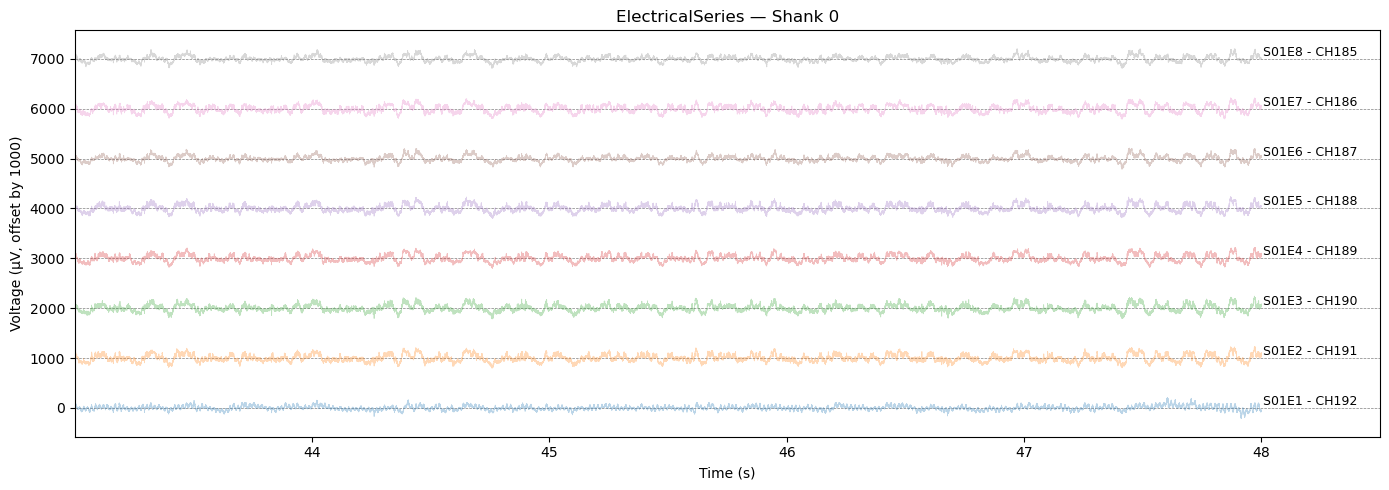

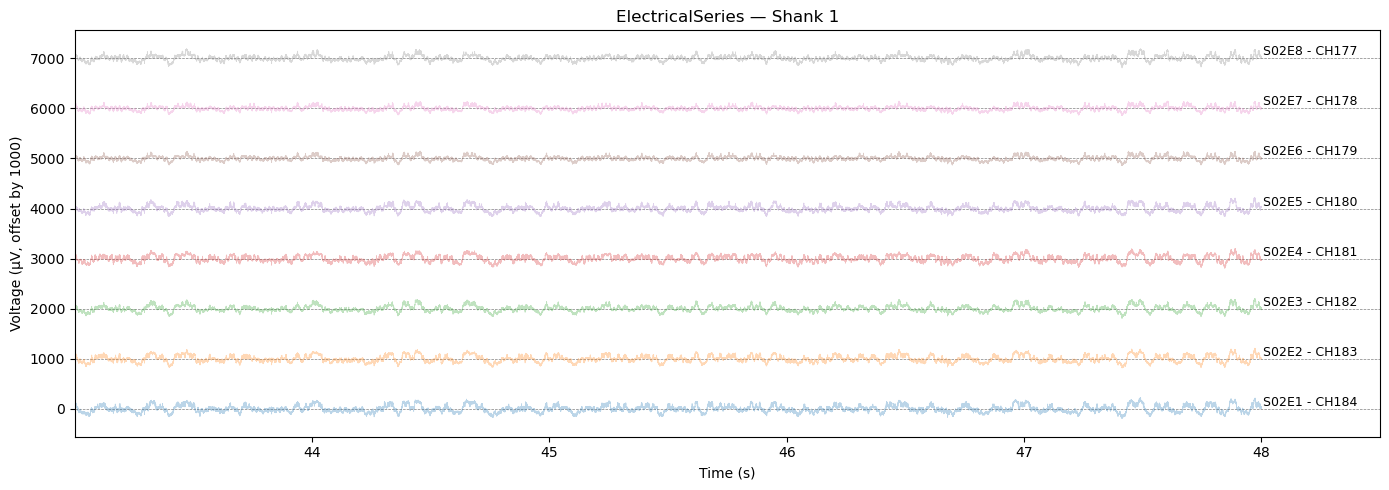

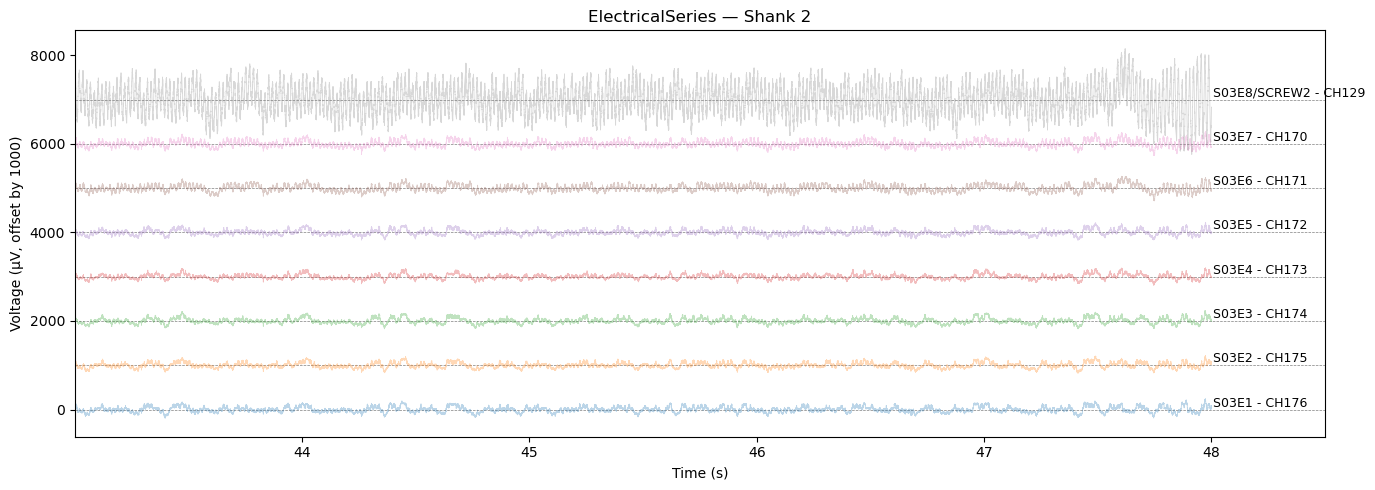

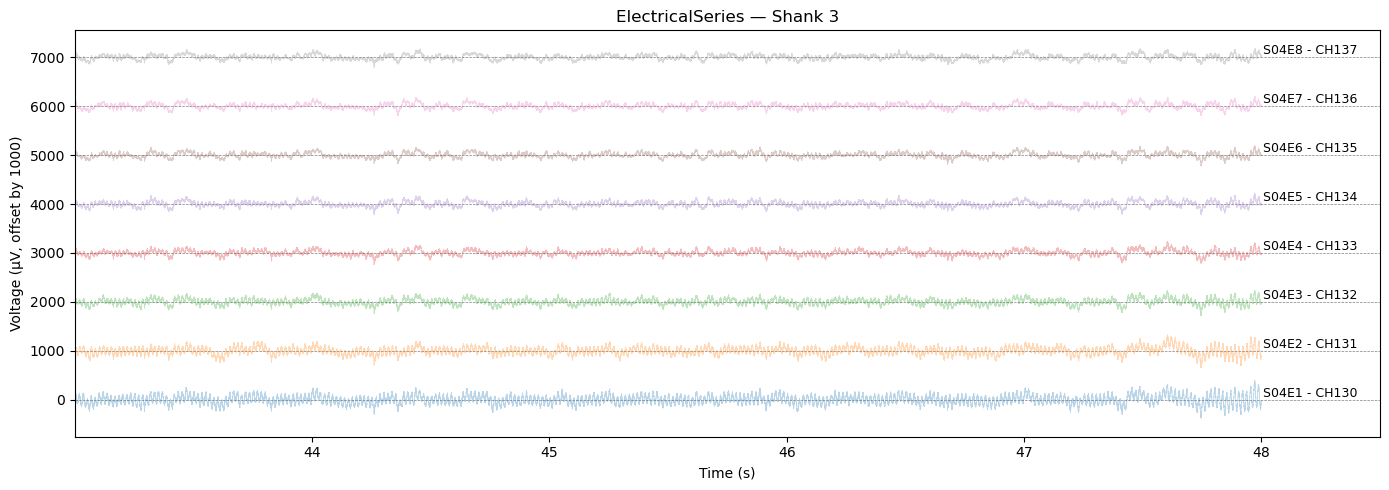

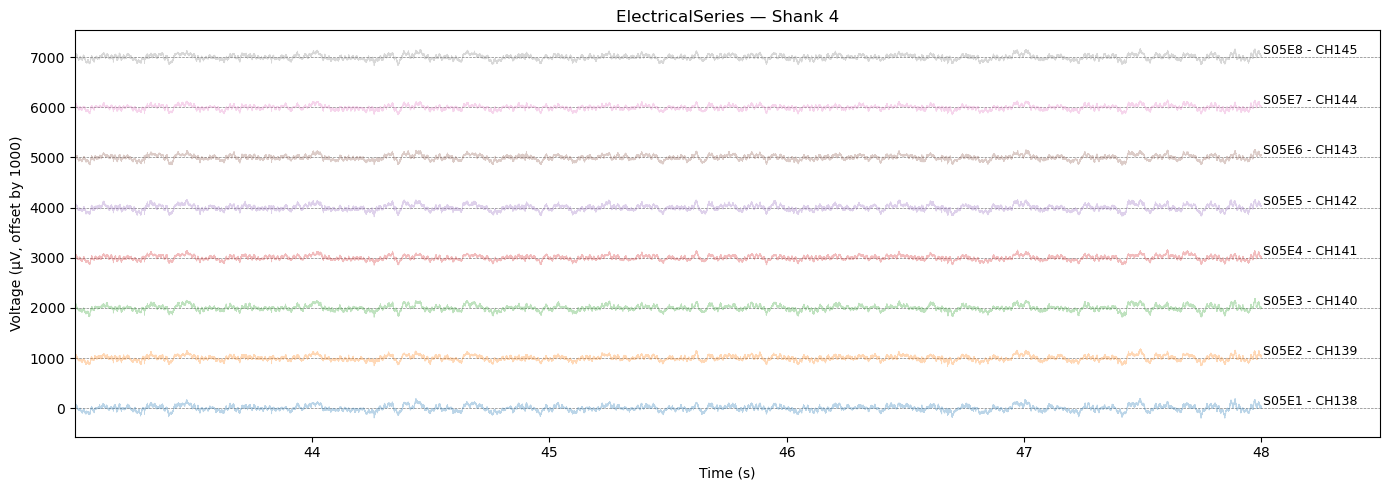

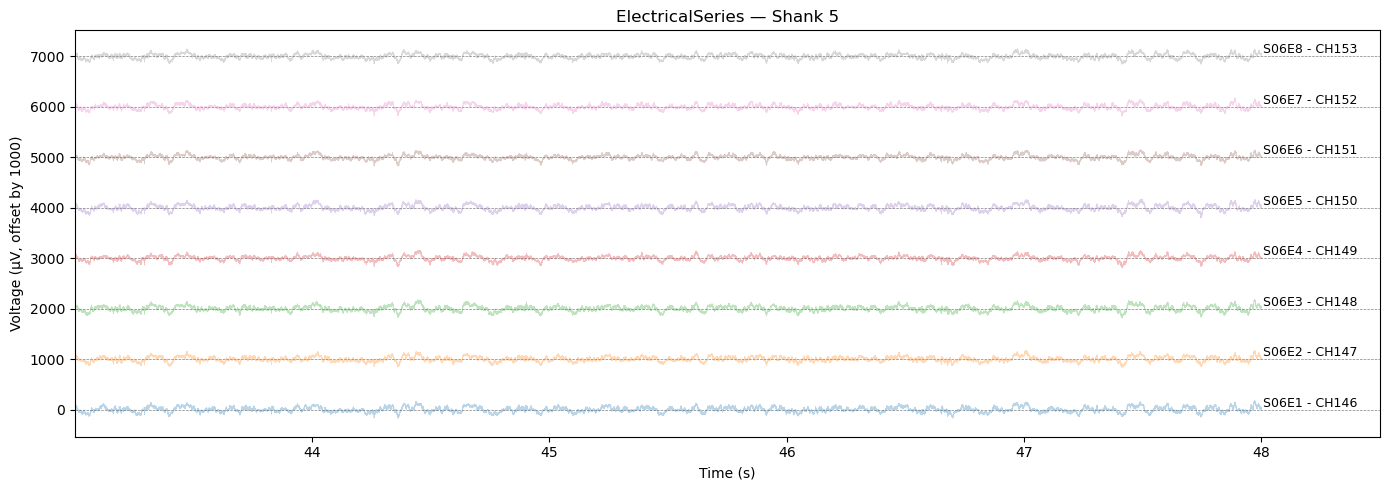

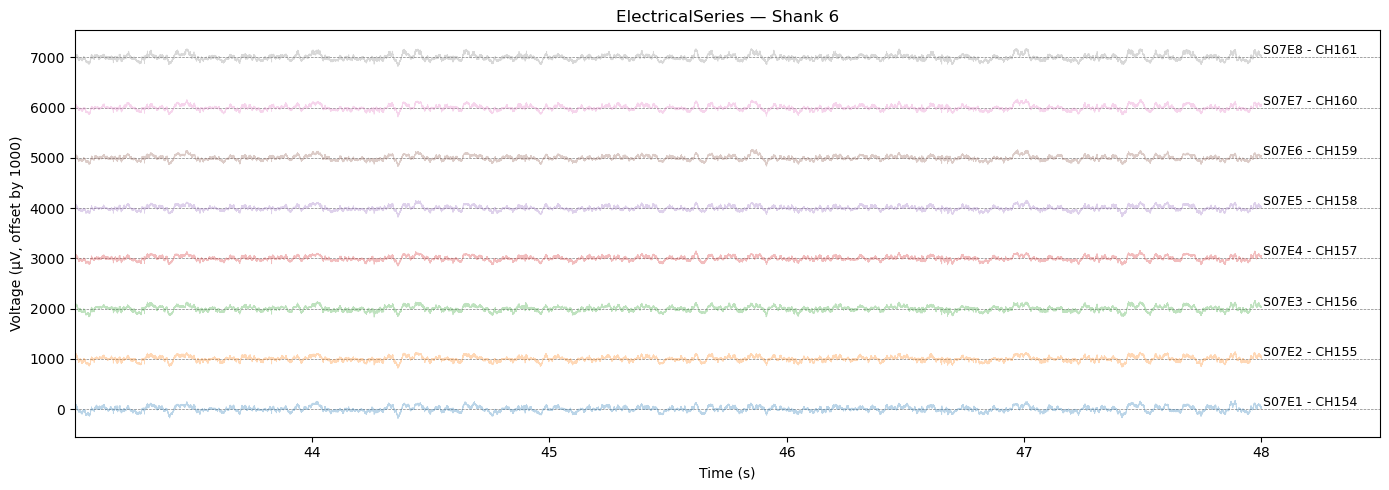

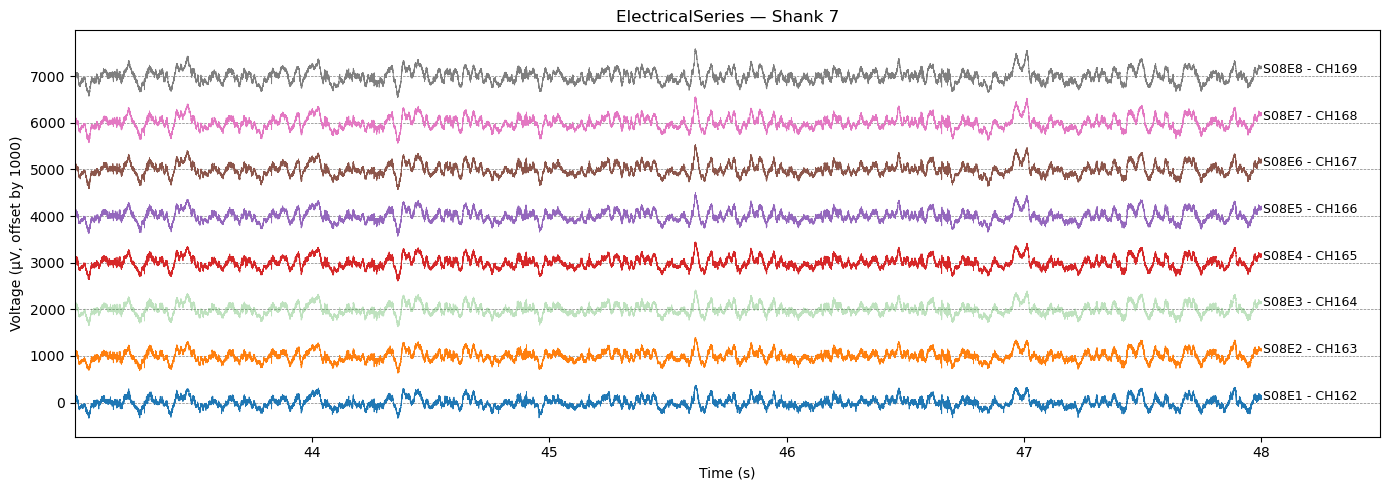

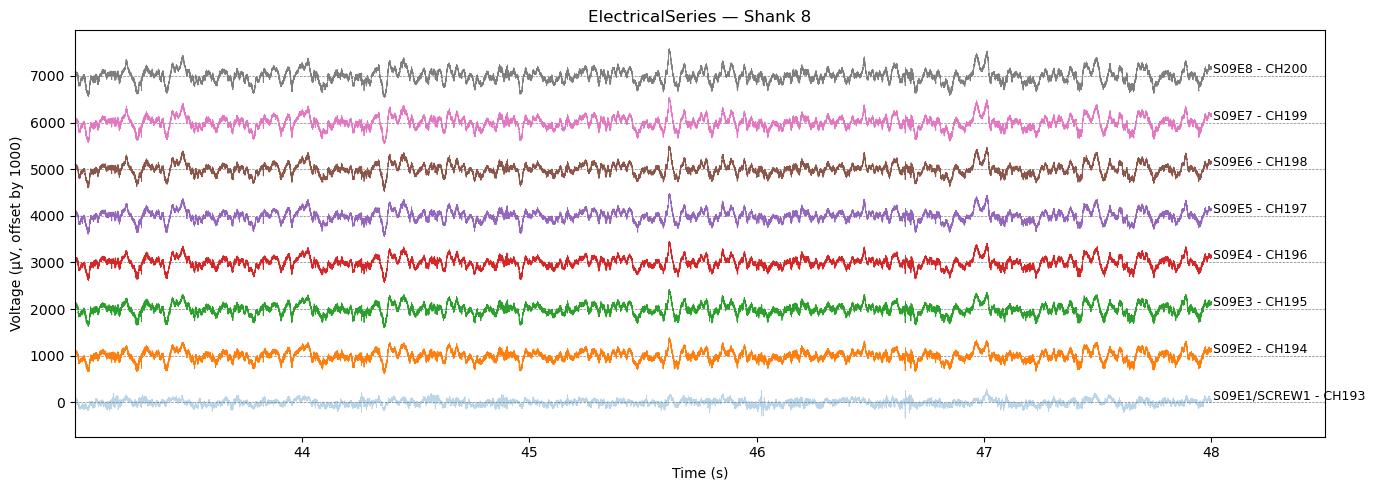

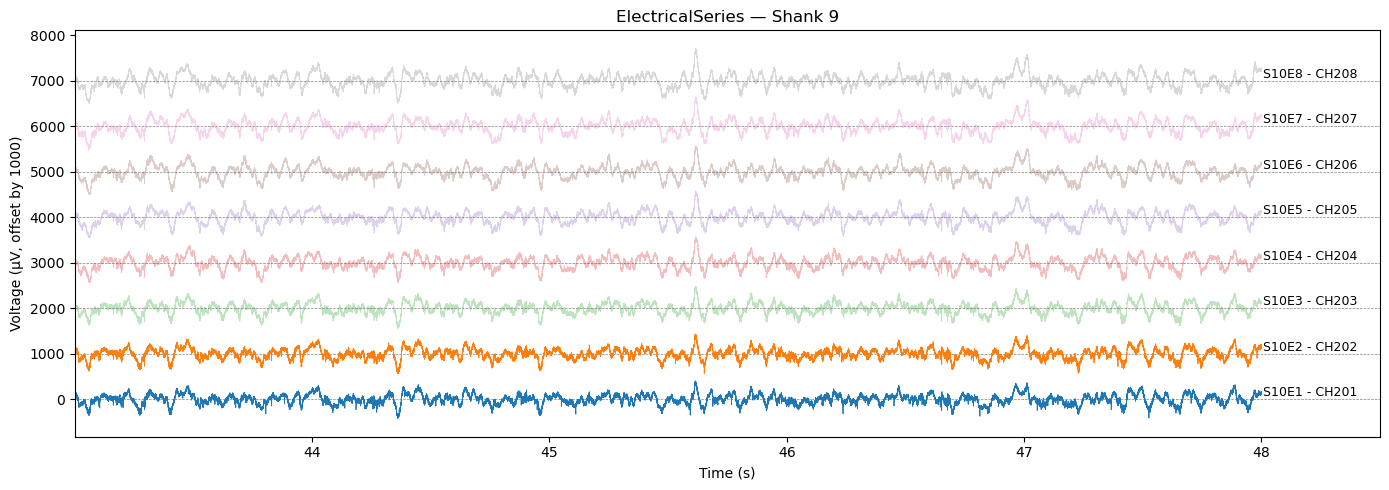

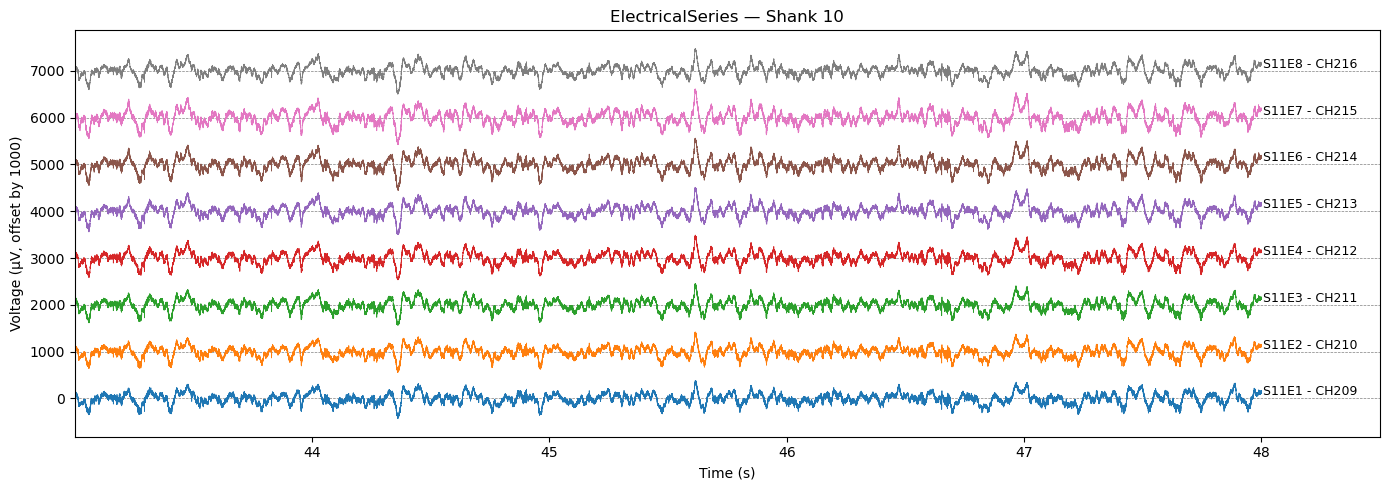

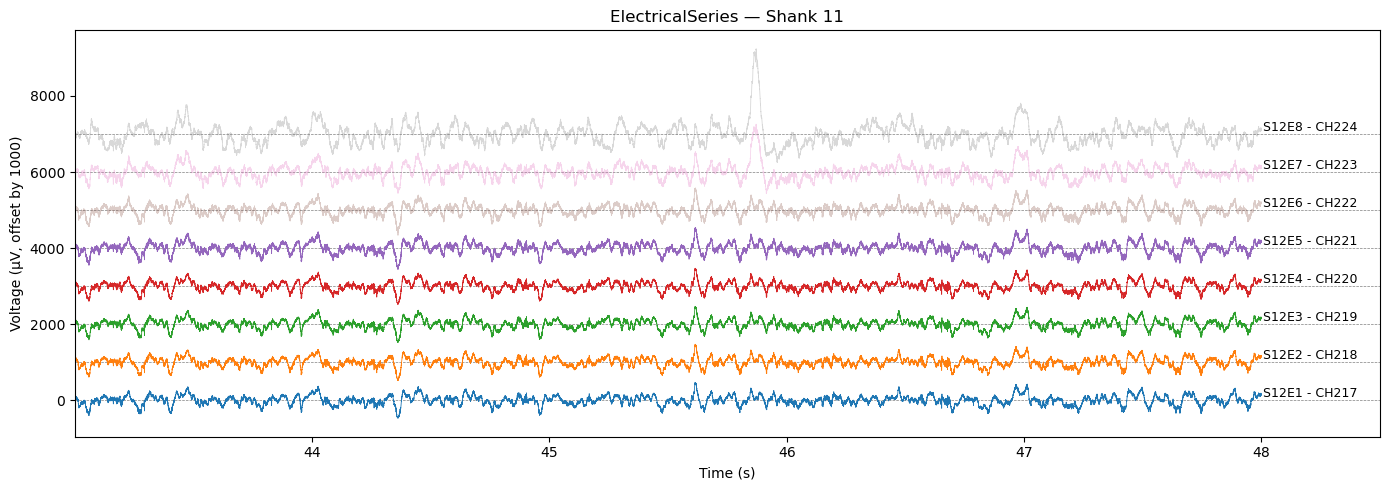

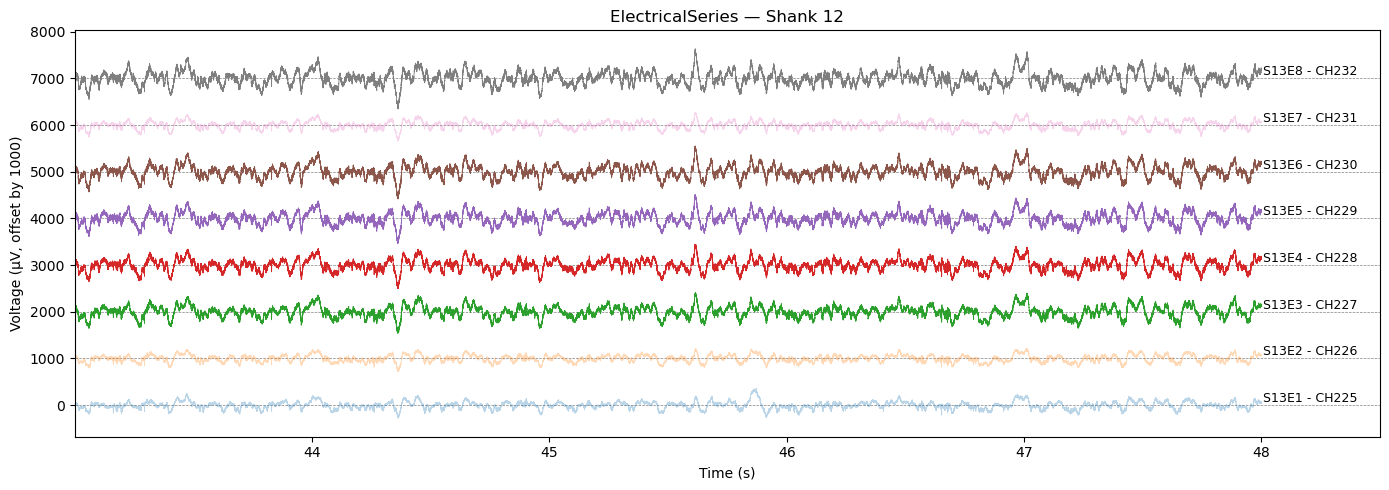

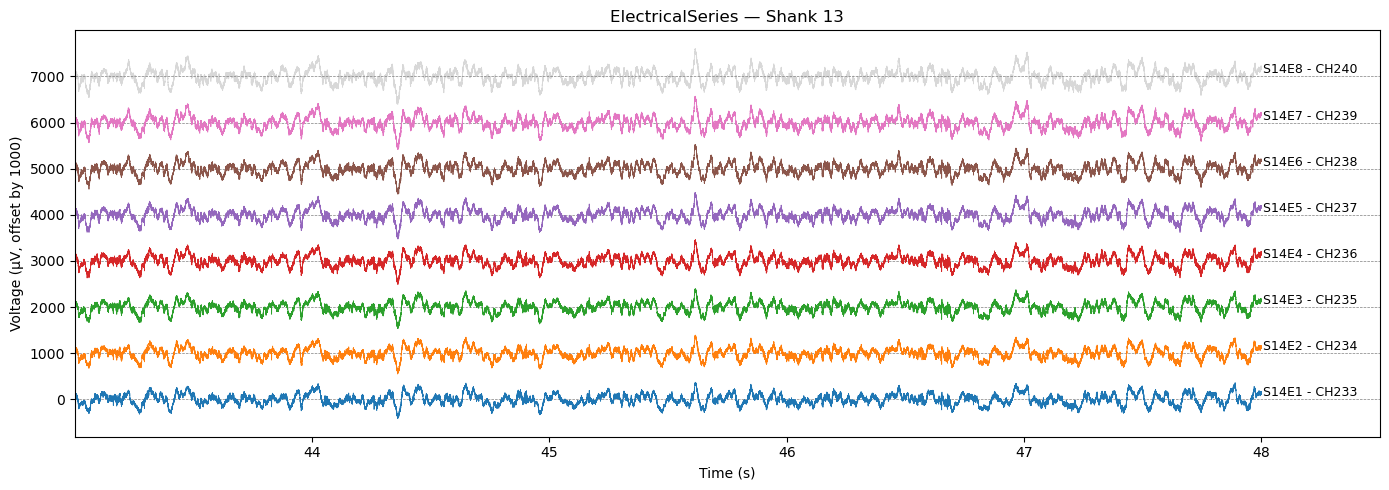

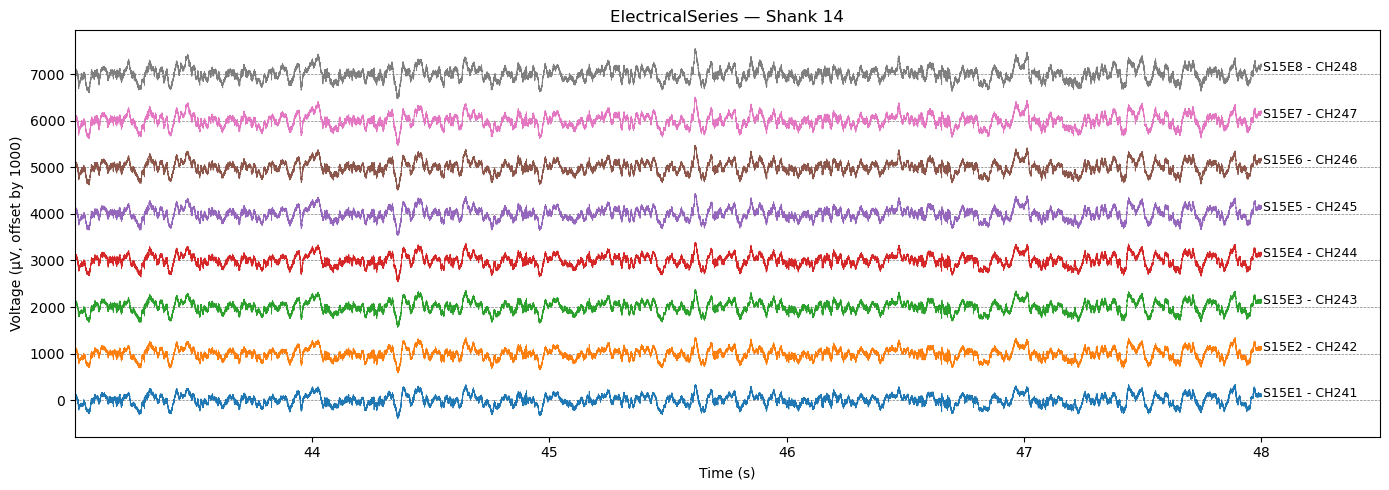

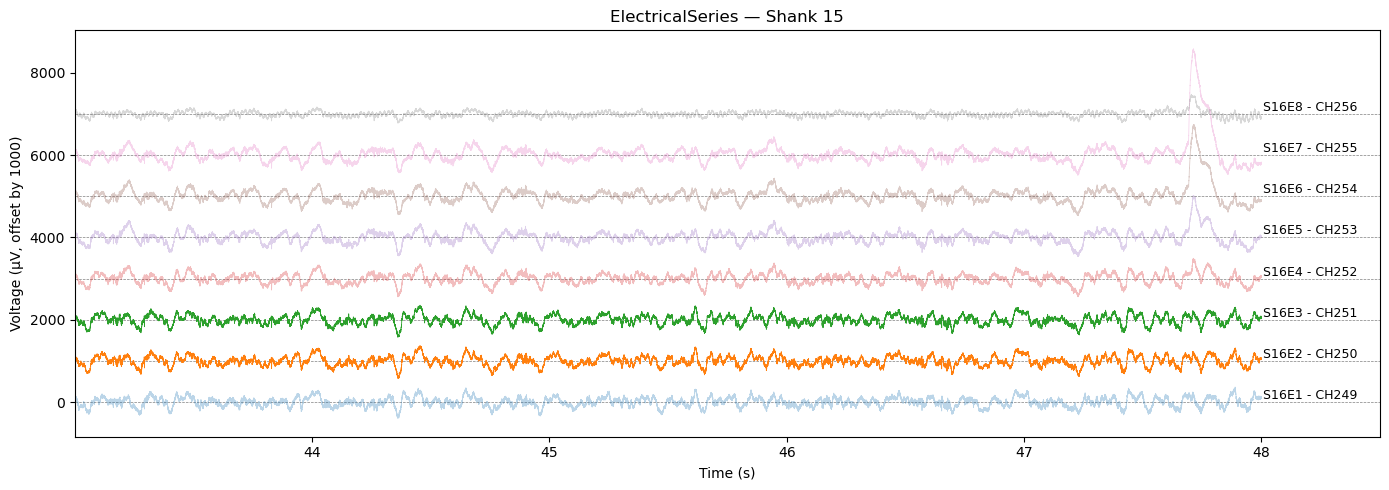

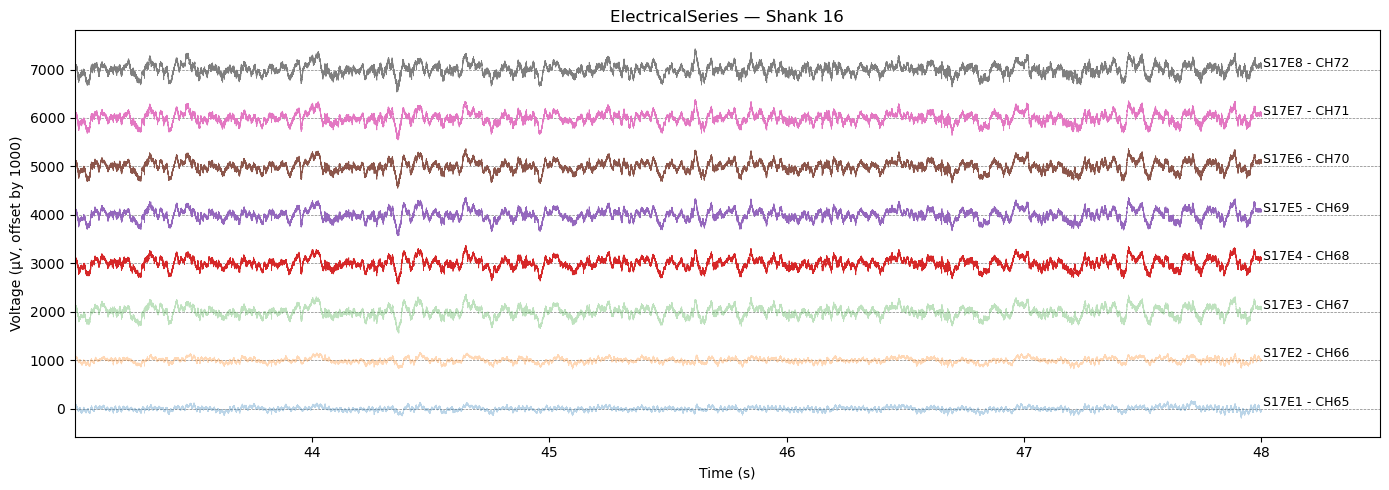

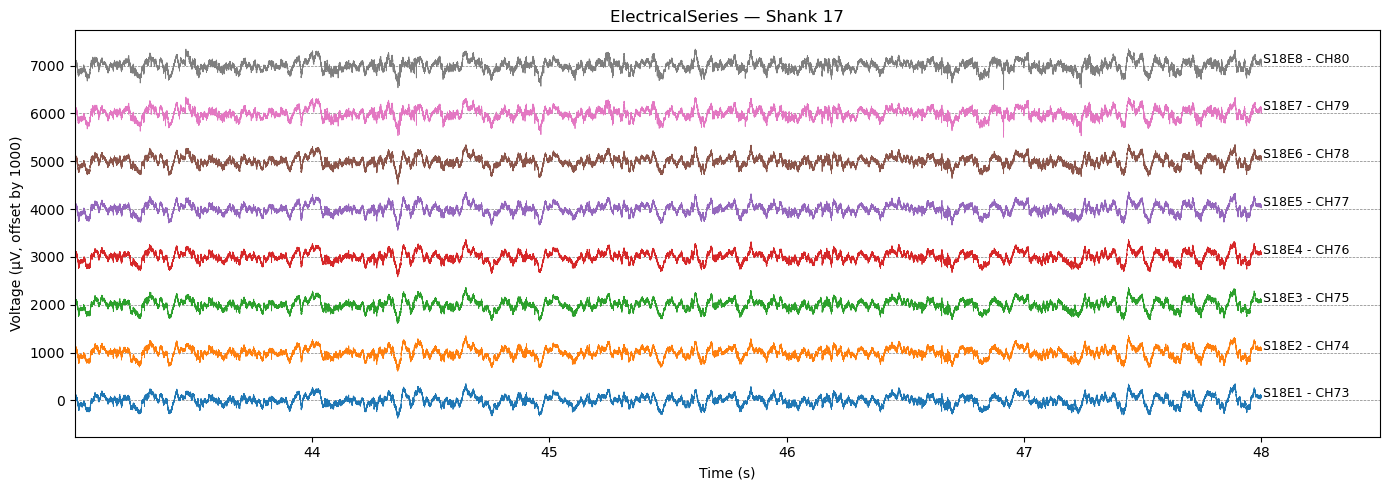

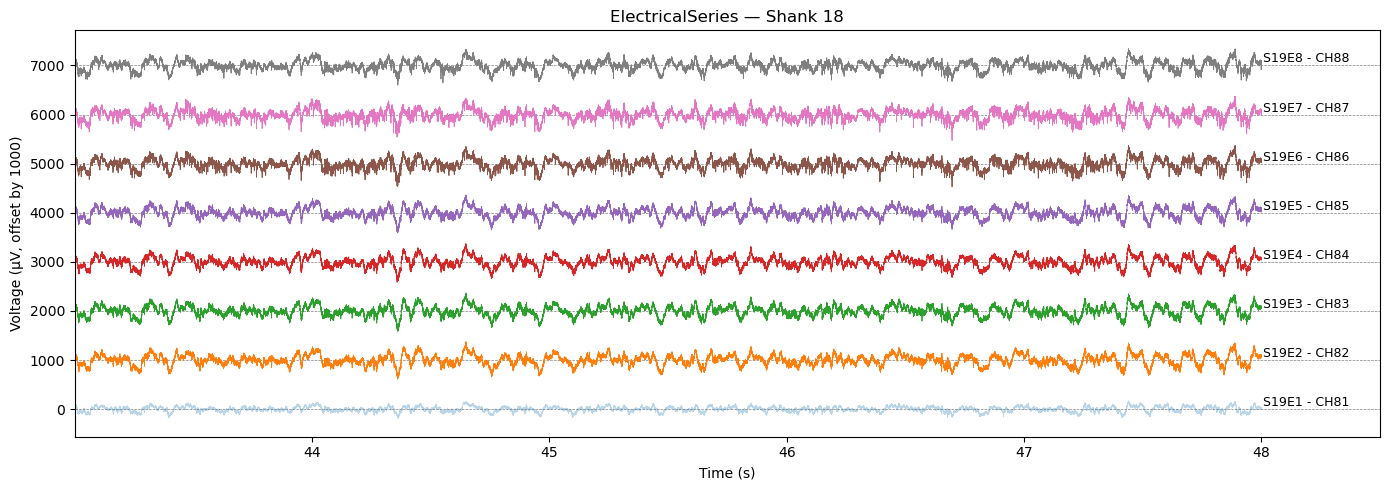

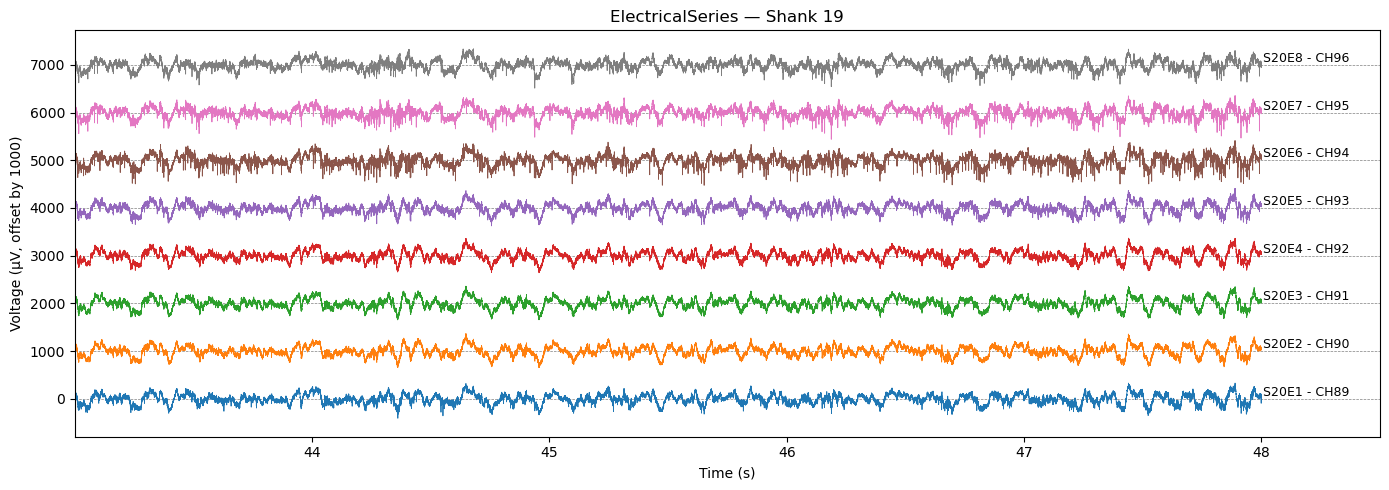

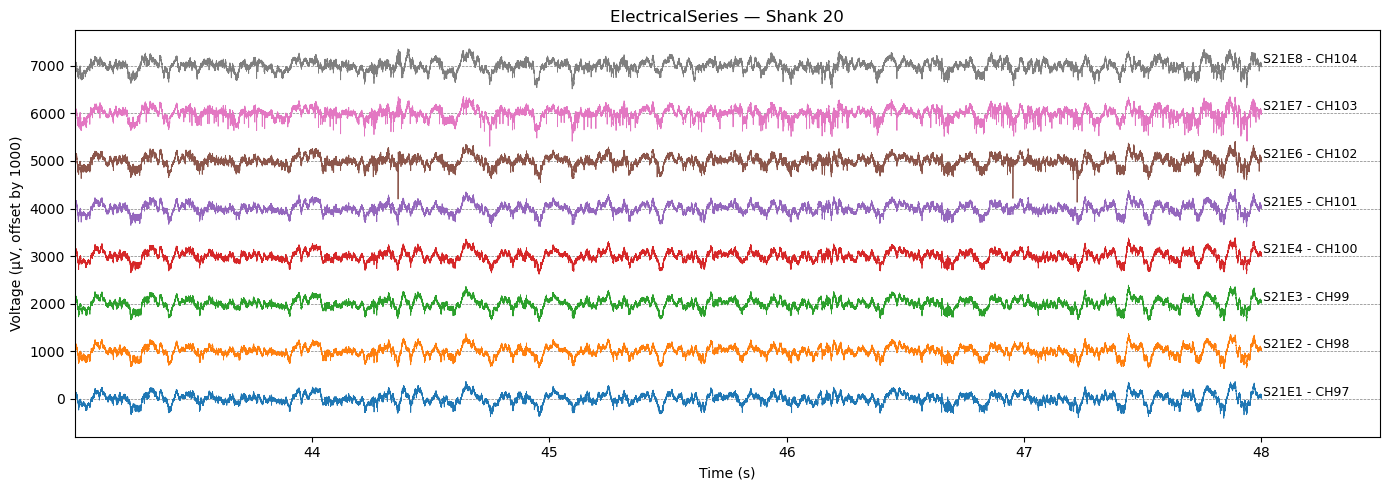

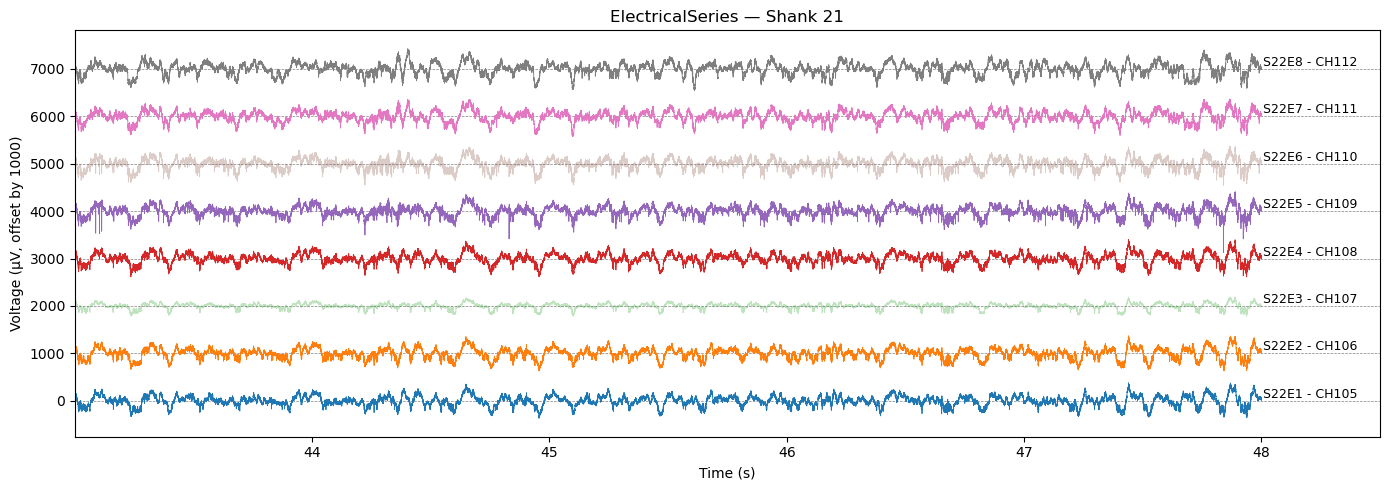

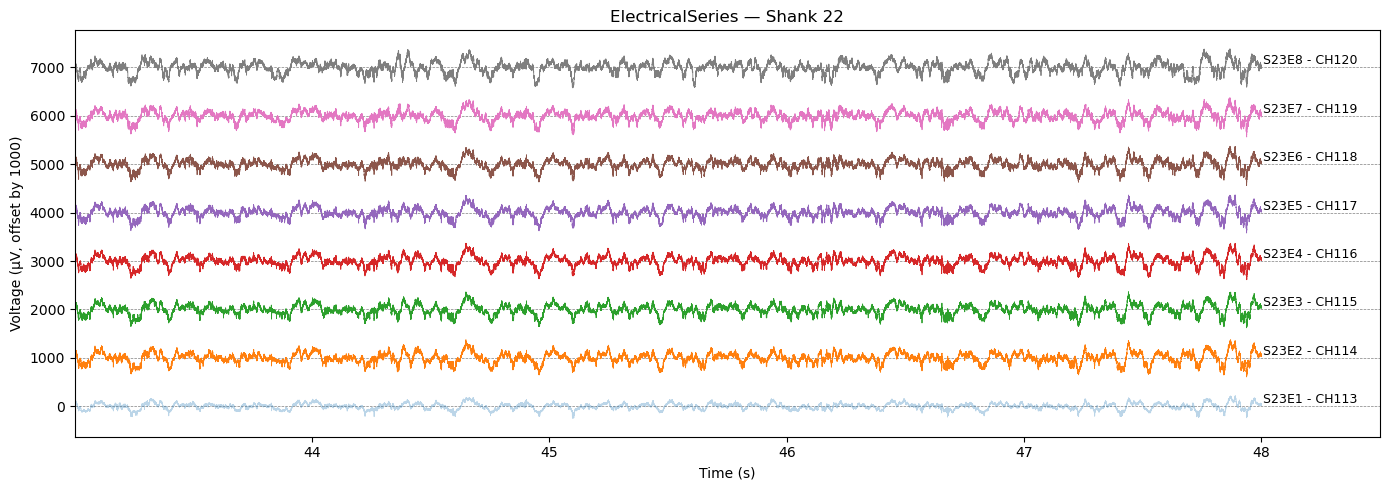

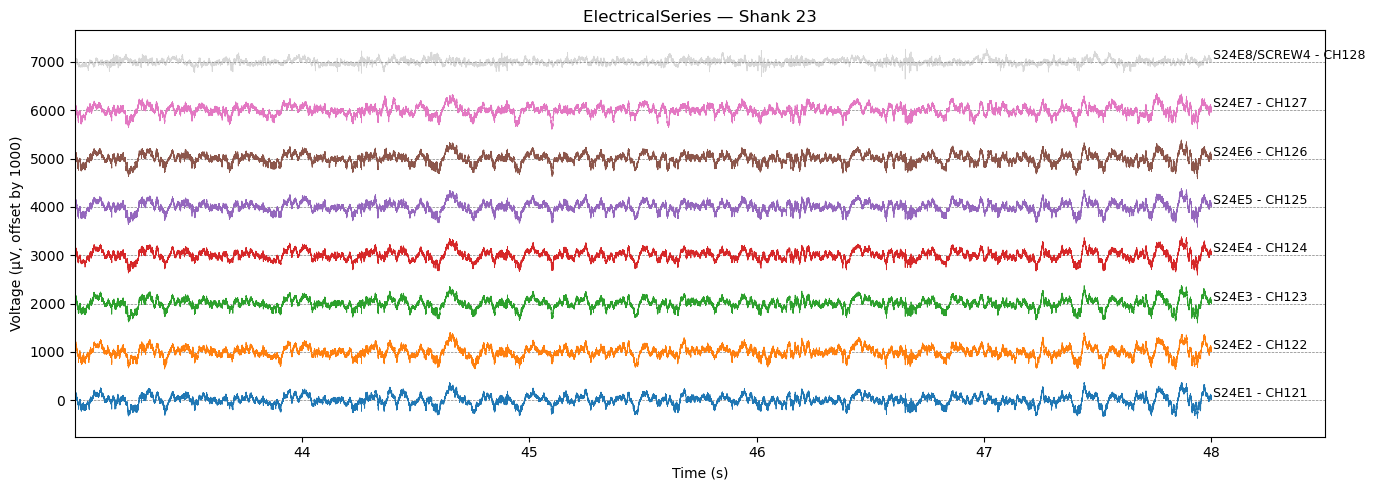

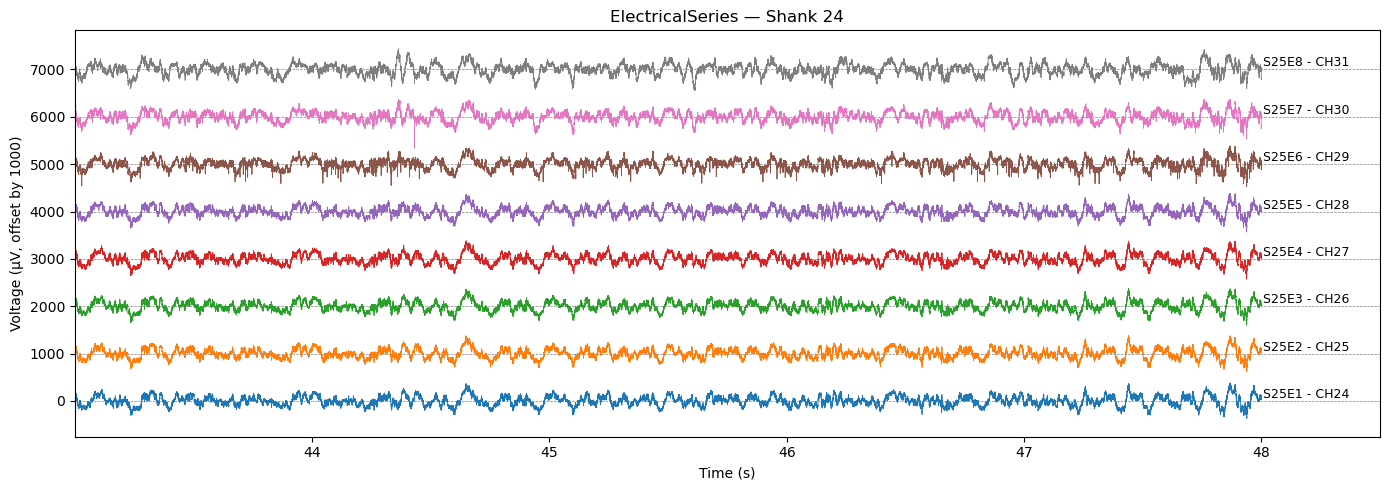

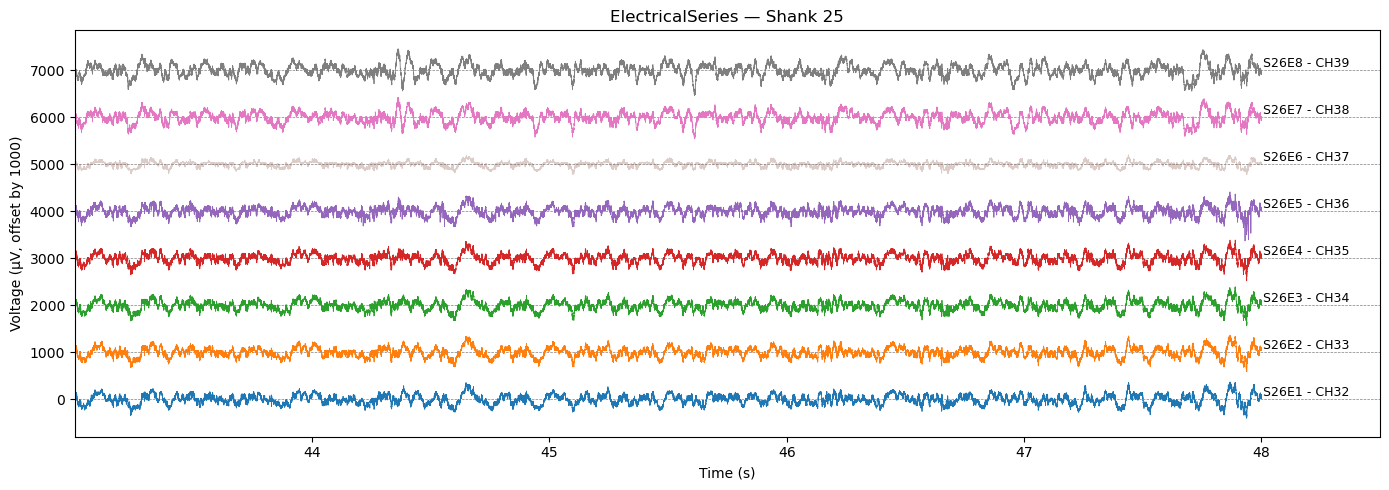

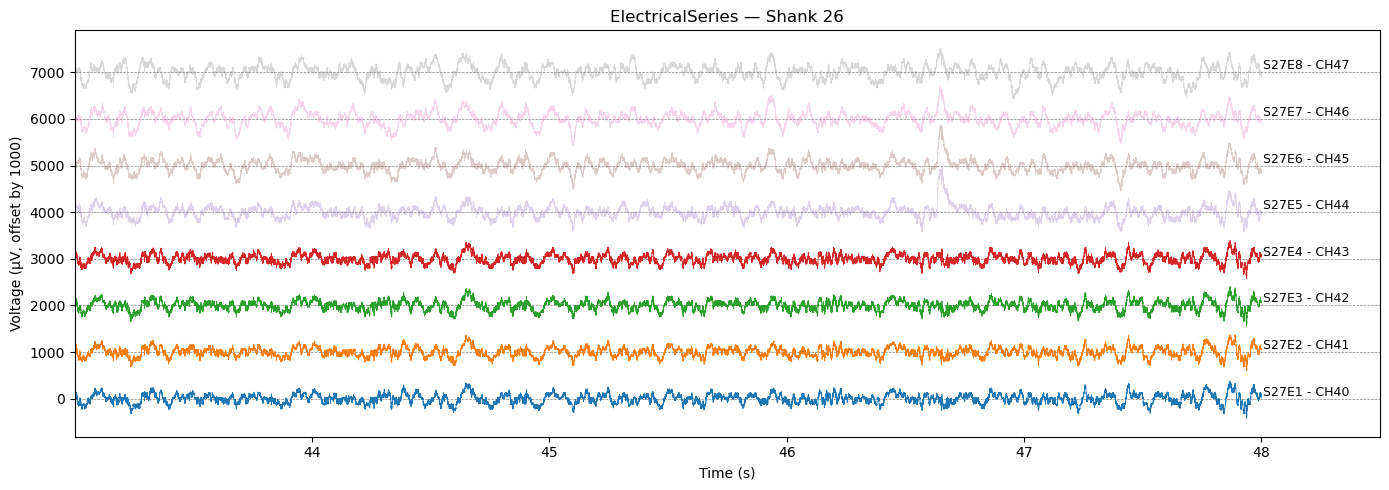

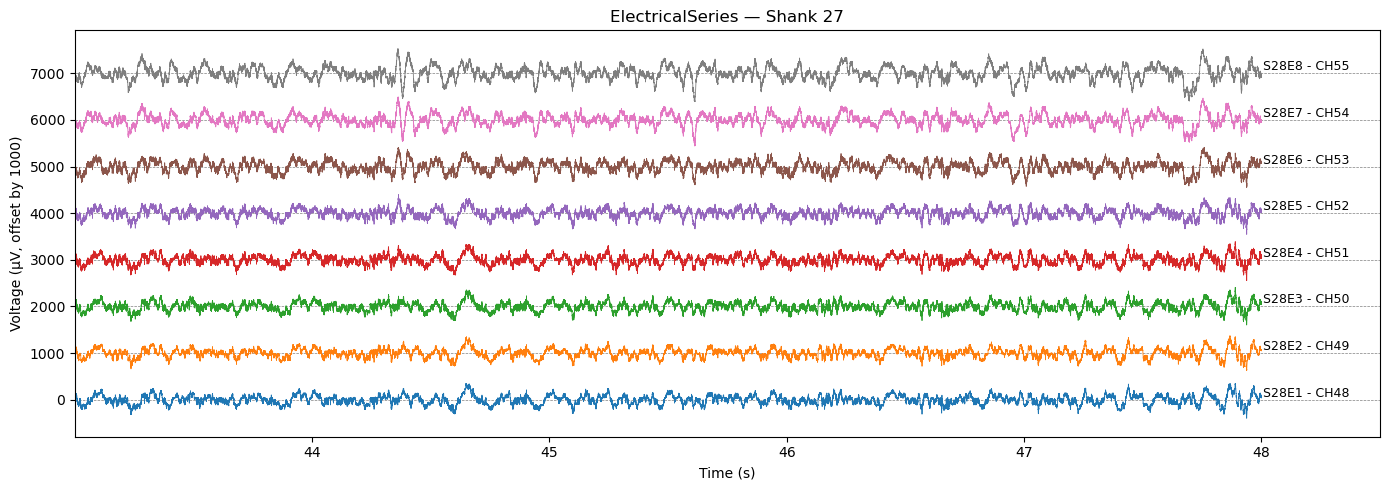

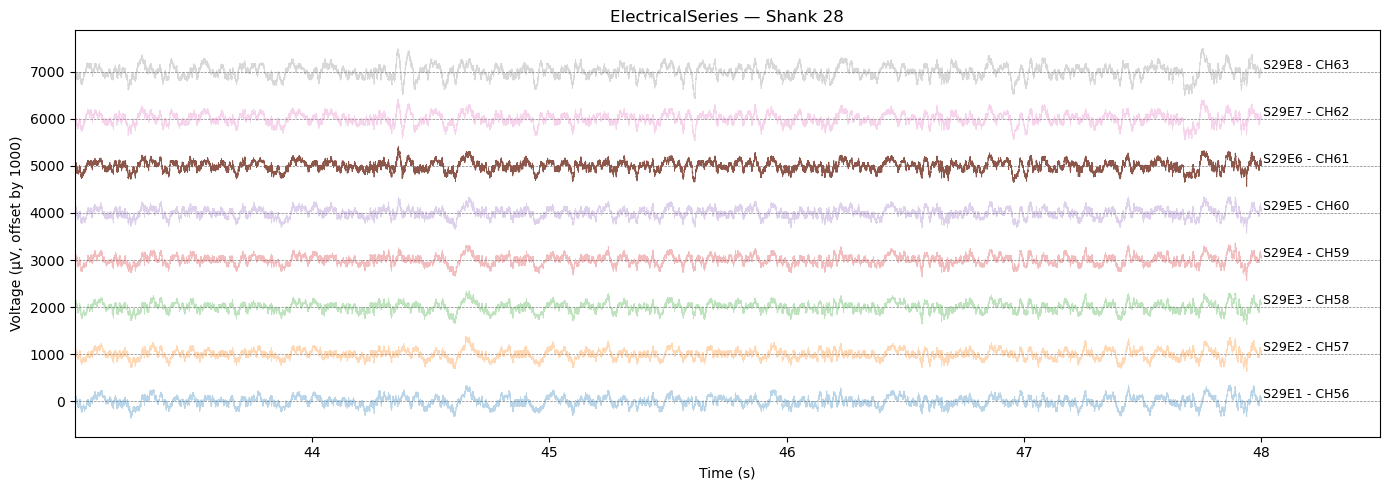

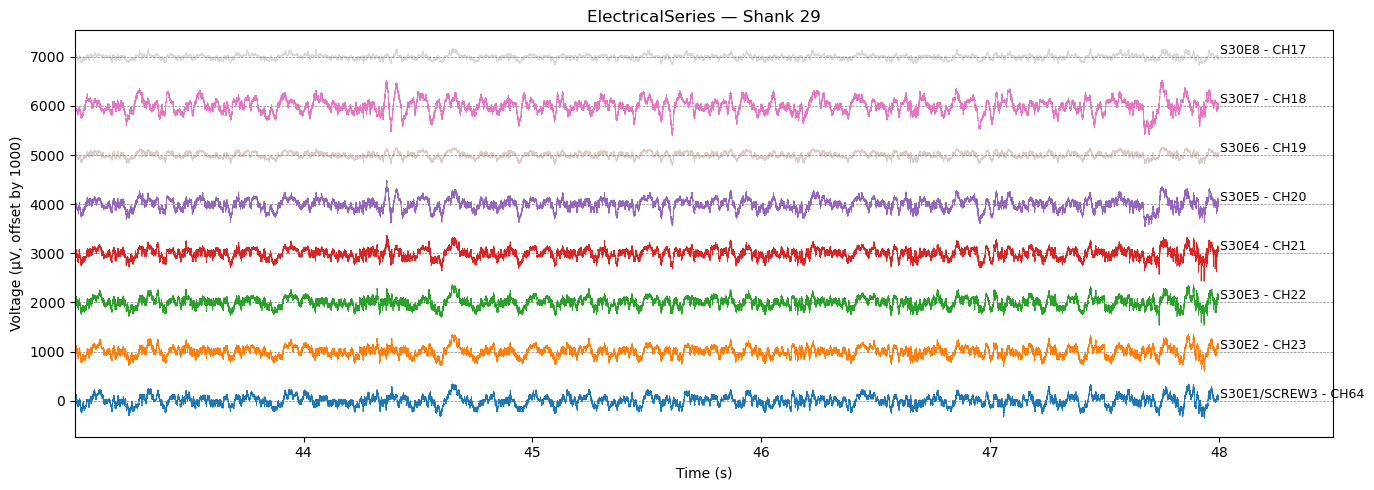

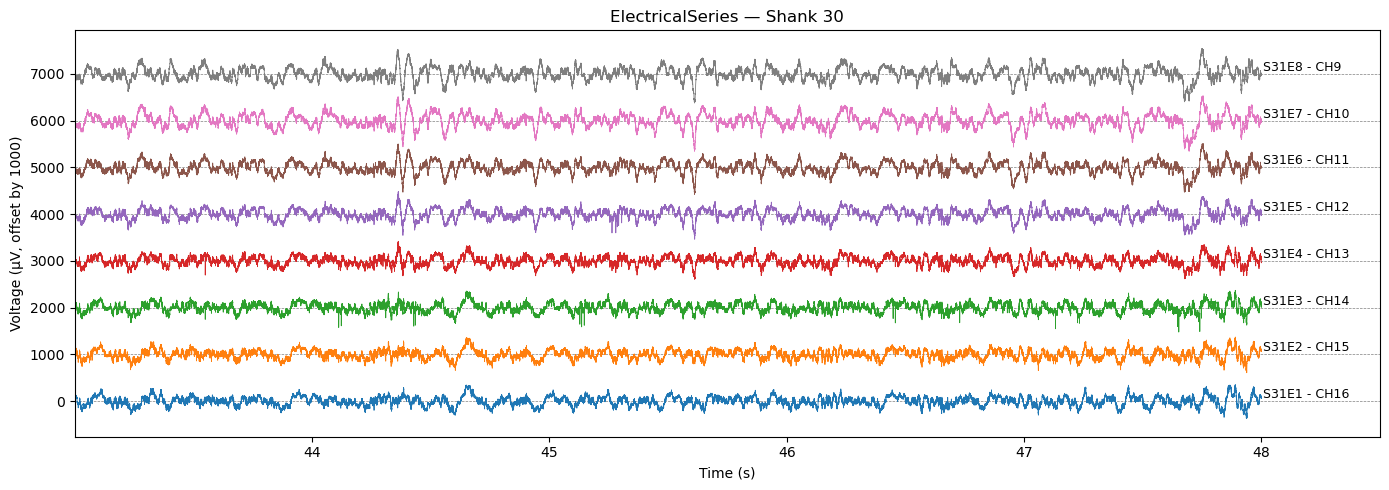

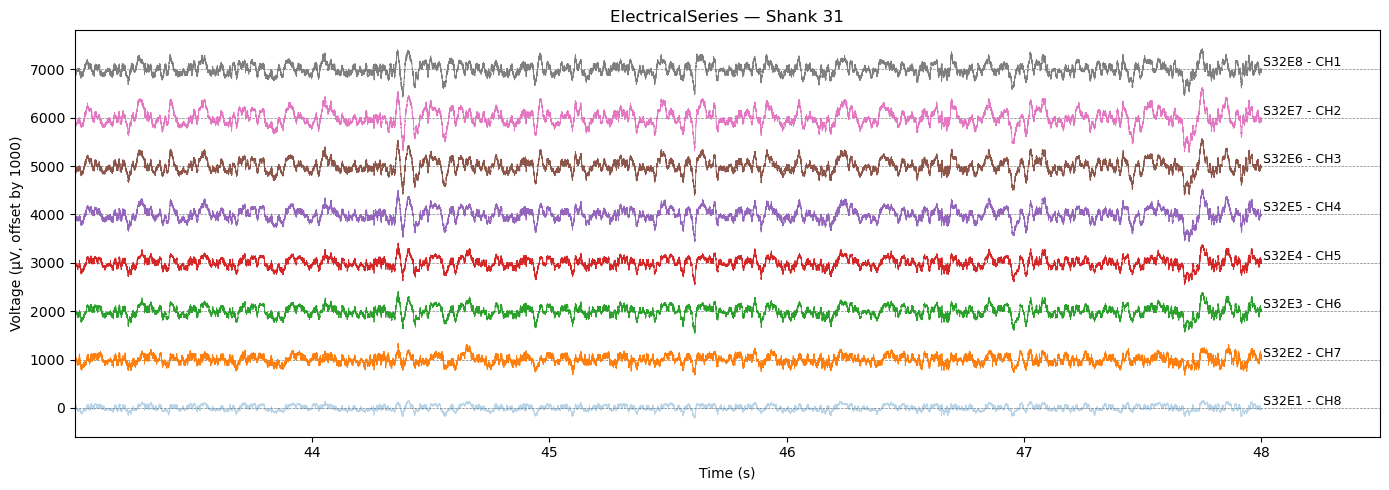

In [10]:
# Define time window
start_time = 43
duration = 5

# Get RAW ElectricalSeries from this nwb
e_series = nwbf.acquisition.get("ElectricalSeries")
timestamps = e_series.timestamps
n_timestamps = len(timestamps)


# Helper to find the first index >= target_time using binary search (because we have non-uniform timestamps)
def find_index(target_time, left=0, right=n_timestamps - 1):
    while left < right:
        mid = (left + right) // 2
        mid_val = timestamps[mid]
        if mid_val < target_time:
            left = mid + 1
        else:
            right = mid
    return left


# Find start and end indices using binary search (without loading all)
start_idx = find_index(start_time)
end_idx = find_index(start_time + duration)


def safe_index(vector_data, indices):
    """Helper to index NWB VectorData columns (works around HDF5 ordering limits)"""
    indices = np.asarray(indices)
    order = np.argsort(indices)
    sorted_vals = np.array(vector_data[indices[order]])
    return sorted_vals[np.argsort(order)]


t = timestamps[start_idx:end_idx]
data_chunk = e_series.data[start_idx:end_idx, :]  # lazy slice, all channels
electrode_table = nwbf.electrodes
electrode_region = e_series.electrodes
electrode_ids = electrode_region.data[:]  # indices into the electrode table

shanks = safe_index(electrode_table["probe_shank"], electrode_ids)
electrodes = safe_index(electrode_table["probe_electrode"], electrode_ids)
electrode_names = safe_index(electrode_table["electrode_name"], electrode_ids)
open_ephys_names = safe_index(electrode_table["open_ephys_channel_str"], electrode_ids)
bad_channels = safe_index(electrode_table["bad_channel"], electrode_ids)

offset = 1000
unique_shanks = np.unique(shanks)
for shank in unique_shanks:
    # Select and sort electrodes within this shank
    shank_mask = shanks == shank
    sort_idx = np.argsort(electrodes[shank_mask])
    # Apply mask and sort
    data_shank = data_chunk[:, shank_mask][:, sort_idx]
    names_shank = electrode_names[shank_mask][sort_idx]
    chan_shank = open_ephys_names[shank_mask][sort_idx]
    bad_shank = bad_channels[shank_mask][sort_idx]
    plt.figure(figsize=(14, 5))
    for i in range(data_shank.shape[1]):
        y = data_shank[:, i] + i * offset
        plt.axhline(i * offset, color="gray", linestyle="--", lw=0.5)
        alpha = 0.3 if bad_shank[i] else 1.0
        plt.plot(t, y, lw=0.6, alpha=alpha)
        label = f"{names_shank[i]} - {chan_shank[i]}"
        plt.text(
            t[-1] + 0.001 * (t[-1] - t[0]), i * offset, label, va="bottom", fontsize=9
        )
    plt.xlabel("Time (s)")
    plt.ylabel("Voltage (µV, offset by 1000)")
    plt.title(f"{e_series.name} — Shank {shank}")
    plt.xlim(t[0], t[0] + duration * 1.1)
    plt.tight_layout()
    plt.show()

## Plot preprocessed ElectricalSeries

This plots a chunk of `recording = sgs.SpikeSortingRecording.get_recording(spikesorting_group_key)` for each SortGroup.



In [11]:
# for spikesorting_group_key in group_keys:
#     recording = sgs.SpikeSortingRecording.get_recording(spikesorting_group_key)
    
#     num_channels = recording.get_num_channels()
#     channel_ids = recording.get_channel_ids()
#     timestamps = recording.get_times()
    
#     data_shank = recording.get_traces(start_frame=start_idx, end_frame=end_idx)
#     time_axis = timestamps[start_idx:end_idx]
    
#     plt.figure(figsize=(14, 5))
#     for i in range(num_channels):
#         y = data_shank[:, i] + i * offset
#         plt.axhline(i * offset, color='gray', linestyle='--', lw=0.5)
#         plt.plot(t, y, lw=0.6, alpha=alpha)
#         label = f"{channel_ids[i]}"
#         plt.text(t[-1] + 0.001*(t[-1]-t[0]), i * offset, label,
#                  va='bottom', fontsize=9)
#     plt.xlabel("Time (s)")
#     plt.ylabel("Voltage (µV, offset by 1000)")
#     plt.title(f"Recording ID {spikesorting_group_key['recording_id']}")
#     plt.xlim(t[0], t[0] + duration * 1.1)
#     plt.tight_layout()
#     plt.show()

## Artifact Detection

In [12]:
print(group_keys)

artifact_detection_keys = []

for group_key in group_keys:
    key = {
        "recording_id": group_key["recording_id"],
        "artifact_param_name": artifact_param_name,
    }
    # Insert into the selection table
    sgs.ArtifactDetectionSelection.insert_selection(key)

    # Grab the primary key (artifact_id) and add to our list so we can insert into ArtifactDetection
    artifact_detection_keys.append((sgs.ArtifactDetectionSelection & key).fetch1("KEY"))

# Look at everything we inserted!
display(sgs.ArtifactDetectionSelection() & artifact_detection_keys)

print("Artifact detection keys:")
print(artifact_detection_keys)

[11:49:11][WARNING] Spyglass: Similar row(s) already inserted.
[11:49:11][WARNING] Spyglass: Similar row(s) already inserted.
[11:49:11][WARNING] Spyglass: Similar row(s) already inserted.
[11:49:11][WARNING] Spyglass: Similar row(s) already inserted.
[11:49:11][WARNING] Spyglass: Similar row(s) already inserted.
[11:49:11][WARNING] Spyglass: Similar row(s) already inserted.
[11:49:11][WARNING] Spyglass: Similar row(s) already inserted.
[11:49:11][WARNING] Spyglass: Similar row(s) already inserted.
[11:49:11][WARNING] Spyglass: Similar row(s) already inserted.
[11:49:11][WARNING] Spyglass: Similar row(s) already inserted.
[11:49:11][WARNING] Spyglass: Similar row(s) already inserted.
[11:49:11][WARNING] Spyglass: Similar row(s) already inserted.
[11:49:11][WARNING] Spyglass: Similar row(s) already inserted.
[11:49:11][WARNING] Spyglass: Similar row(s) already inserted.
[11:49:11][WARNING] Spyglass: Similar row(s) already inserted.
[11:49:11][WARNING] Spyglass: Similar row(s) already in

[{'recording_id': UUID('a65a3777-8463-4102-a8d2-1762db005e78')}, {'recording_id': UUID('e0952299-f248-4a4d-b76c-afb9f6509f7e')}, {'recording_id': UUID('d633be23-2afa-4462-9560-d48c5ce86606')}, {'recording_id': UUID('8b048ecb-3578-40ee-b6bd-2caef3120fc0')}, {'recording_id': UUID('9115eb77-fafb-4888-bc4e-a1c2e2bb44c9')}, {'recording_id': UUID('8983541d-5a68-449f-9ad7-eb83969f5e65')}, {'recording_id': UUID('5ab62e88-3084-475e-b103-f92ff0125571')}, {'recording_id': UUID('8ce3fbd7-d514-4f18-b09e-e236606e91ac')}, {'recording_id': UUID('44be71a2-1b32-4ec6-b4f1-94183ebf8d03')}, {'recording_id': UUID('0f842cb2-3cbc-443a-9fdb-313cf9a0b677')}, {'recording_id': UUID('72afaa63-cd1e-42aa-9725-2209df1b72f1')}, {'recording_id': UUID('f9bafbaa-16e1-4383-aefe-31f1e2389f32')}, {'recording_id': UUID('272c7b3b-b2e1-4f38-bff2-731eaa500200')}, {'recording_id': UUID('1a338894-ba66-4093-827b-dec28cd84e9a')}, {'recording_id': UUID('e8e0ddb7-5479-479a-b4f5-88a67c285e24')}, {'recording_id': UUID('da38ea83-bfa6-4e

[11:49:11][WARNING] Spyglass: Similar row(s) already inserted.
[11:49:11][WARNING] Spyglass: Similar row(s) already inserted.
[11:49:11][WARNING] Spyglass: Similar row(s) already inserted.


*artifact_id   recording_id   artifact_param
+------------+ +------------+ +------------+
08f843d1-f4c7- dc888c0c-f575- ampl_1000_z_30
14130f54-9d03- 5ab62e88-3084- ampl_1000_z_30
218ffa74-c438- 0f842cb2-3cbc- ampl_1000_z_30
2a668284-a594- 1a338894-ba66- ampl_1000_z_30
322766e1-3b95- 8ce3fbd7-d514- ampl_1000_z_30
3521b4f0-ff2e- 8b048ecb-3578- ampl_1000_z_30
427cc63a-87f4- 9115eb77-fafb- ampl_1000_z_30
42ea08fc-4ca3- e8e0ddb7-5479- ampl_1000_z_30
44c715b7-ce22- 6dc40531-d29e- ampl_1000_z_30
512c1749-03fb- 272c7b3b-b2e1- ampl_1000_z_30
6a606657-daca- e0952299-f248- ampl_1000_z_30
7d843334-1e6c- 44be71a2-1b32- ampl_1000_z_30
   ...
 (Total: 24)

Artifact detection keys:
[{'artifact_id': UUID('99f40bc8-1175-44b2-9824-1c5270dd4602')}, {'artifact_id': UUID('6a606657-daca-4fc1-9a4b-b9684d96968e')}, {'artifact_id': UUID('bb324fb7-454b-4c20-923e-3497ac3277b6')}, {'artifact_id': UUID('3521b4f0-ff2e-450d-b031-c5a93b009872')}, {'artifact_id': UUID('427cc63a-87f4-4e0c-ba9d-3a3cbf3a3731')}, {'artifact_id': UUID('8b128ef6-7e1d-4e74-9eb7-04733e9ad0c2')}, {'artifact_id': UUID('14130f54-9d03-4930-b578-e8fc82a3865a')}, {'artifact_id': UUID('322766e1-3b95-42af-a07f-673b4532f6c0')}, {'artifact_id': UUID('7d843334-1e6c-4a5c-8282-05bf540cc4cd')}, {'artifact_id': UUID('218ffa74-c438-4ceb-9a29-093de72fdf09')}, {'artifact_id': UUID('fd852e07-d1bd-4d4c-9ca9-a67ad20ab804')}, {'artifact_id': UUID('c6f3ce13-48ae-4ff0-86c8-0b127063a491')}, {'artifact_id': UUID('512c1749-03fb-40ba-8bb2-85712139e13d')}, {'artifact_id': UUID('2a668284-a594-40c4-ba18-37b1a8961ffe')}, {'artifact_id': UUID('42ea08fc-4ca3-4b8d-887e-9909a6d7814c')}, {'artifact_id': UUID('8297289

Now call the `populate` method of `ArtifactDetection`.

Instead of just calling `sgs.ArtifactDetection.populate(artifact_detection_keys)` with all artifact_detection_keys, we only populate the missing keys.

In [13]:
# Populate ArtifactDetection for all artifact_detection_keys (ignoring ones already populated)

# Print the set of all possible keys
print(f"There are {len(artifact_detection_keys)} keys: {artifact_detection_keys}")

# Get the set of already-populated keys in ArtifactDetection
existing_keys = (sgs.ArtifactDetection & artifact_detection_keys).fetch(
    "KEY", as_dict=True
)
print(
    f"There are {len(existing_keys)} already in in ArtifactDetection: {existing_keys}"
)

# Find missing keys
missing_keys = [key for key in artifact_detection_keys if key not in existing_keys]
print(f"There are {len(missing_keys)} missing keys: {missing_keys}")

# Populate only missing entries
if missing_keys:
    sgs.ArtifactDetection().populate(missing_keys)
else:
    print("All group keys already populated.")

There are 24 keys: [{'artifact_id': UUID('99f40bc8-1175-44b2-9824-1c5270dd4602')}, {'artifact_id': UUID('6a606657-daca-4fc1-9a4b-b9684d96968e')}, {'artifact_id': UUID('bb324fb7-454b-4c20-923e-3497ac3277b6')}, {'artifact_id': UUID('3521b4f0-ff2e-450d-b031-c5a93b009872')}, {'artifact_id': UUID('427cc63a-87f4-4e0c-ba9d-3a3cbf3a3731')}, {'artifact_id': UUID('8b128ef6-7e1d-4e74-9eb7-04733e9ad0c2')}, {'artifact_id': UUID('14130f54-9d03-4930-b578-e8fc82a3865a')}, {'artifact_id': UUID('322766e1-3b95-42af-a07f-673b4532f6c0')}, {'artifact_id': UUID('7d843334-1e6c-4a5c-8282-05bf540cc4cd')}, {'artifact_id': UUID('218ffa74-c438-4ceb-9a29-093de72fdf09')}, {'artifact_id': UUID('fd852e07-d1bd-4d4c-9ca9-a67ad20ab804')}, {'artifact_id': UUID('c6f3ce13-48ae-4ff0-86c8-0b127063a491')}, {'artifact_id': UUID('512c1749-03fb-40ba-8bb2-85712139e13d')}, {'artifact_id': UUID('2a668284-a594-40c4-ba18-37b1a8961ffe')}, {'artifact_id': UUID('42ea08fc-4ca3-4b8d-887e-9909a6d7814c')}, {'artifact_id': UUID('82972894-7dce

In [14]:
# Make sure everything worked!
display(sgs.ArtifactDetection() & artifact_detection_keys)

*artifact_id  
+------------+
08f843d1-f4c7-
14130f54-9d03-
218ffa74-c438-
2a668284-a594-
322766e1-3b95-
3521b4f0-ff2e-
427cc63a-87f4-
42ea08fc-4ca3-
44c715b7-ce22-
512c1749-03fb-
6a606657-daca-
7d843334-1e6c-
   ...
 (Total: 24)

## Run Spike Sorting

The spike sorting pipeline is powered by `spikeinterface`, a community-developed Python package that enables one to easily apply multiple spike sorters to a single recording. Some spike sorters have special requirements, such as GPU. Others need to be installed separately from spyglass. In the Frank lab, we have been using `mountainsort4`, though the pipeline have been tested with `mountainsort5`, `kilosort2_5`, `kilosort3`, and `ironclust` as well.

When using `mountainsort5`, make sure to run `pip install mountainsort5`. `kilosort2_5`, `kilosort3`, and `ironclust` are MATLAB-based, but we can run these without having to install MATLAB thanks to `spikeinterface`. It does require downloading additional files (as singularity containers) so make sure to do `pip install spython`. These sorters also require GPU access, so also do ` pip install cuda-python` (and make sure your computer does have a GPU). 

In [15]:
# Insert into SpikeSortingSelection

spike_sorting_keys = []

for group_key in group_keys:
    # Sometimes not all of these correctly populated in ArtifactDetectionSelection but we want to move forward anyway.
    # So we do a check that the interval list actually exists so we can move forward with the ones that did
    art_id = (
        sgs.ArtifactDetectionSelection & {"recording_id": group_key["recording_id"]}
    ).fetch1("artifact_id")
    interval_list_entry = sgc.IntervalList() & {"interval_list_name": str(art_id)}
    if len(interval_list_entry.fetch()) == 0:
        print(f"No interval list entry for {art_id}, skipping.")
        continue

    ss_key = {
        "recording_id": group_key["recording_id"],
        "sorter": sorter,
        "nwb_file_name": nwb_file_name,
        "interval_list_name": str(art_id),
        "sorter_param_name": sorter_param_name,
    }
    # Insert into the selection table
    sgs.SpikeSortingSelection.insert_selection(ss_key)

    # Grab the primary key (sorting_id) and add to our list so we can insert into SpikeSorting
    spike_sorting_keys.append((sgs.SpikeSortingSelection & ss_key).proj().fetch1("KEY"))

# Look at everything we inserted!
display(sgs.SpikeSortingSelection() & spike_sorting_keys)

print("Spike sorting keys:")
print(spike_sorting_keys)

[11:49:23][INFO] Spyglass: Similar row(s) already inserted.
INFO:spyglass:Similar row(s) already inserted.
[11:49:24][INFO] Spyglass: Similar row(s) already inserted.
INFO:spyglass:Similar row(s) already inserted.
[11:49:24][INFO] Spyglass: Similar row(s) already inserted.
INFO:spyglass:Similar row(s) already inserted.
[11:49:25][INFO] Spyglass: Similar row(s) already inserted.
INFO:spyglass:Similar row(s) already inserted.
[11:49:25][INFO] Spyglass: Similar row(s) already inserted.
INFO:spyglass:Similar row(s) already inserted.
[11:49:25][INFO] Spyglass: Similar row(s) already inserted.
INFO:spyglass:Similar row(s) already inserted.
[11:49:26][INFO] Spyglass: Similar row(s) already inserted.
INFO:spyglass:Similar row(s) already inserted.
[11:49:26][INFO] Spyglass: Similar row(s) already inserted.
INFO:spyglass:Similar row(s) already inserted.
[11:49:26][INFO] Spyglass: Similar row(s) already inserted.
INFO:spyglass:Similar row(s) already inserted.
[11:49:27][INFO] Spyglass: Similar ro

*sorting_id    recording_id   sorter         sorter_param_n nwb_file_name  interval_list_
+------------+ +------------+ +------------+ +------------+ +------------+ +------------+
12070414-97c1- 272c7b3b-b2e1- mountainsort4  franklab_tetro IM-1478_202207 512c1749-03fb-
1951cd63-1dc6- f9bafbaa-16e1- mountainsort4  franklab_tetro IM-1478_202207 c6f3ce13-48ae-
1d068dc1-a52d- 8983541d-5a68- mountainsort4  franklab_tetro IM-1478_202207 8b128ef6-7e1d-
1dca6fa8-a9e3- 8b048ecb-3578- mountainsort4  franklab_tetro IM-1478_202207 3521b4f0-ff2e-
23ebaf39-330f- e8e0ddb7-5479- mountainsort4  franklab_tetro IM-1478_202207 42ea08fc-4ca3-
28620b2c-2ddc- 5a76c8b4-9974- mountainsort4  franklab_tetro IM-1478_202207 c1b1061a-c5a8-
38eacf23-041c- a65a3777-8463- mountainsort4  franklab_tetro IM-1478_202207 99f40bc8-1175-
3af73696-7bb6- 9115eb77-fafb- mountainsort4  franklab_tetro IM-1478_202207 427cc63a-87f4-
6247fa2f-eed2- da38ea83-bfa6- mountainsort4  franklab_tetro IM-1478_202207 82972894-7dce-
8c7b7ed6-4440- e0952299-f248- mountainsort4  franklab_tetro IM-1478_202207 6a606657-daca-
94db3ced-a352- 842d48b0-8574- mountainsort4  franklab_tetro IM-1478_202207 dd53cec6-a2da-
98cbb921-5b54- 44be71a2-1b32- mountainsort4  franklab_tetro IM-1478_202207 7d843334-1e6c-
   ...
 (Total: 24)

Spike sorting keys:
[{'sorting_id': UUID('38eacf23-041c-4186-b138-435cd76eef9a')}, {'sorting_id': UUID('8c7b7ed6-4440-4c88-85c4-2dd333d7b8b9')}, {'sorting_id': UUID('ec211032-3bca-4faa-a10c-bc59b70993be')}, {'sorting_id': UUID('1dca6fa8-a9e3-42de-9e92-7f181f357bdf')}, {'sorting_id': UUID('3af73696-7bb6-4d1d-9851-4fc187bb137a')}, {'sorting_id': UUID('1d068dc1-a52d-470e-aebc-3ddb8fe865a0')}, {'sorting_id': UUID('d82062ab-7d94-4f81-bed0-e62978150dc4')}, {'sorting_id': UUID('e2ab51df-f582-4c9c-ad04-76349931d8f9')}, {'sorting_id': UUID('98cbb921-5b54-4372-99cf-714b3cf3cbc4')}, {'sorting_id': UUID('d4ea2f7b-ec2c-43a5-b7ad-658e892e12f7')}, {'sorting_id': UUID('f0af06d9-b87c-4e07-81d1-d065eb6ba646')}, {'sorting_id': UUID('1951cd63-1dc6-4ed0-8521-c8ff0d78a450')}, {'sorting_id': UUID('12070414-97c1-420a-b14e-ffd76d446d76')}, {'sorting_id': UUID('e73caa08-d79c-45ad-95ee-8ef5e7fc6ab1')}, {'sorting_id': UUID('23ebaf39-330f-4ddb-b2d7-fb0720e7929b')}, {'sorting_id': UUID('6247fa2f-eed2-4c33-b044-2be7

Now call the `populate` method of `SpikeSorting`.

Instead of just calling `sgs.SpikeSorting.populate(spike_sorting_keys)` with all spike_sorting_keys, we only populate the missing keys.

In [16]:
# Populate SpikeSorting for all spike_sorting_keys (ignoring ones already populated)

# Print the set of all possible keys
print(f"There are {len(spike_sorting_keys)} keys: {spike_sorting_keys}")

# Get the set of already-populated keys in sgs.SpikeSorting
existing_keys = (sgs.SpikeSorting & spike_sorting_keys).fetch("KEY", as_dict=True)
print(f"There are {len(existing_keys)} already in in sgs.SpikeSorting: {existing_keys}")

# Find missing keys
missing_keys = [key for key in spike_sorting_keys if key not in existing_keys]
print(f"There are {len(missing_keys)} missing keys: {missing_keys}")

# Populate only missing entries
if missing_keys:
    sgs.SpikeSorting.populate(missing_keys)
else:
    print("All group keys already populated.")

There are 24 keys: [{'sorting_id': UUID('38eacf23-041c-4186-b138-435cd76eef9a')}, {'sorting_id': UUID('8c7b7ed6-4440-4c88-85c4-2dd333d7b8b9')}, {'sorting_id': UUID('ec211032-3bca-4faa-a10c-bc59b70993be')}, {'sorting_id': UUID('1dca6fa8-a9e3-42de-9e92-7f181f357bdf')}, {'sorting_id': UUID('3af73696-7bb6-4d1d-9851-4fc187bb137a')}, {'sorting_id': UUID('1d068dc1-a52d-470e-aebc-3ddb8fe865a0')}, {'sorting_id': UUID('d82062ab-7d94-4f81-bed0-e62978150dc4')}, {'sorting_id': UUID('e2ab51df-f582-4c9c-ad04-76349931d8f9')}, {'sorting_id': UUID('98cbb921-5b54-4372-99cf-714b3cf3cbc4')}, {'sorting_id': UUID('d4ea2f7b-ec2c-43a5-b7ad-658e892e12f7')}, {'sorting_id': UUID('f0af06d9-b87c-4e07-81d1-d065eb6ba646')}, {'sorting_id': UUID('1951cd63-1dc6-4ed0-8521-c8ff0d78a450')}, {'sorting_id': UUID('12070414-97c1-420a-b14e-ffd76d446d76')}, {'sorting_id': UUID('e73caa08-d79c-45ad-95ee-8ef5e7fc6ab1')}, {'sorting_id': UUID('23ebaf39-330f-4ddb-b2d7-fb0720e7929b')}, {'sorting_id': UUID('6247fa2f-eed2-4c33-b044-2be79

In [17]:
# Make sure everything worked!
display(sgs.SpikeSorting() & spike_sorting_keys)

*sorting_id    analysis_file_ object_id      time_of_sort  
+------------+ +------------+ +------------+ +------------+
12070414-97c1- IM-1478_202207 9d81959c-0ee3- 1765361977    
1951cd63-1dc6- IM-1478_202207 4d770391-1928- 1765362537    
1d068dc1-a52d- IM-1478_202207 e3b2bd5c-282f- 1765362890    
1dca6fa8-a9e3- IM-1478_202207 dd8b54b7-9ee5- 1765363452    
23ebaf39-330f- IM-1478_202207 aa4ef344-0979- 1765363907    
28620b2c-2ddc- IM-1478_202207 d710413d-14f0- 1765364565    
38eacf23-041c- IM-1478_202207 719dc5ab-eb23- 1765365065    
3af73696-7bb6- IM-1478_202207 2651bf8f-1be8- 1765365451    
6247fa2f-eed2- IM-1478_202207 05b9a4ec-ca1e- 1765365980    
8c7b7ed6-4440- IM-1478_202207 cb3f716e-d9e4- 1765366483    
94db3ced-a352- IM-1478_202207 bbde8f50-e517- 1765366833    
98cbb921-5b54- IM-1478_202207 59b23f4a-b1bb- 1765367033    
   ...
 (Total: 24)

The spike sorting results (spike times of detected units) are saved in an NWB file. We can access this in two ways. First, we can access it via the `fetch_nwb` method, which allows us to directly access the spike times saved in the `units` table of the NWB file. Second, we can access it as a `spikeinterface.NWBSorting` object. This allows us to take advantage of the rich APIs of `spikeinterface` to further analyze the sorting. 

In [18]:
# for ss_key in spike_sorting_keys:
#     sorting_nwb = (sgs.SpikeSorting & ss_key).fetch_nwb()
#     sorting_si = sgs.SpikeSorting.get_sorting(ss_key)

Note that the spike times of `fetch_nwb` is in units of seconds aligned with the timestamps of the recording. The spike times of the `spikeinterface.NWBSorting` object is in units of samples (as is generally true for sorting objects in `spikeinterface`).

## Automatic Curation

Next step is to curate the results of spike sorting. This is often necessary because spike sorting algorithms are not perfect;
they often return clusters that are clearly not biological in origin, and sometimes oversplit clusters that should have been merged.
We have two main ways of curating spike sorting: by computing quality metrics followed by thresholding, and manually applying curation labels.
To do either, we first insert the spike sorting to `CurationV1` using `insert_curation` method.


In [19]:
curation_key_list = []

for ss_key in spike_sorting_keys:

    # Check if this sorting_id has already been inserted with curation_id=1
    initial_curation_key = {"sorting_id": str(ss_key["sorting_id"]), "curation_id": 0}
    initial_curation_entry = sgs.CurationV1() & initial_curation_key

    # If it hasn't been inserted yet, insert into the curation table
    if len(initial_curation_entry.fetch()) == 0:
        sgs.CurationV1.insert_curation(
            sorting_id=str(ss_key["sorting_id"]),
            description="initial automatic curation",
        )
    else:
        print(f"Entry for {initial_curation_key} already exists in sgs.CurationV1")

    curation_key_list.append(initial_curation_key)

# Look at everything we inserted!
display(sgs.CurationV1() & curation_key_list)

print("Curation keys (initial automatic curation):")
print(curation_key_list)

Entry for {'sorting_id': '38eacf23-041c-4186-b138-435cd76eef9a', 'curation_id': 0} already exists in sgs.CurationV1
Entry for {'sorting_id': '8c7b7ed6-4440-4c88-85c4-2dd333d7b8b9', 'curation_id': 0} already exists in sgs.CurationV1
Entry for {'sorting_id': 'ec211032-3bca-4faa-a10c-bc59b70993be', 'curation_id': 0} already exists in sgs.CurationV1
Entry for {'sorting_id': '1dca6fa8-a9e3-42de-9e92-7f181f357bdf', 'curation_id': 0} already exists in sgs.CurationV1
Entry for {'sorting_id': '3af73696-7bb6-4d1d-9851-4fc187bb137a', 'curation_id': 0} already exists in sgs.CurationV1
Entry for {'sorting_id': '1d068dc1-a52d-470e-aebc-3ddb8fe865a0', 'curation_id': 0} already exists in sgs.CurationV1
Entry for {'sorting_id': 'd82062ab-7d94-4f81-bed0-e62978150dc4', 'curation_id': 0} already exists in sgs.CurationV1
Entry for {'sorting_id': 'e2ab51df-f582-4c9c-ad04-76349931d8f9', 'curation_id': 0} already exists in sgs.CurationV1
Entry for {'sorting_id': '98cbb921-5b54-4372-99cf-714b3cf3cbc4', 'curati

*sorting_id    *curation_id   parent_curatio analysis_file_ object_id      merges_applied description   
+------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+
12070414-97c1- 0              -1             IM-1478_202207 ff0608df-f743- 0              initial automa
1951cd63-1dc6- 0              -1             IM-1478_202207 8d2a6794-6a86- 0              initial automa
1d068dc1-a52d- 0              -1             IM-1478_202207 eb6e033a-302d- 0              initial automa
1dca6fa8-a9e3- 0              -1             IM-1478_202207 7e4eb9d9-3b63- 0              initial automa
23ebaf39-330f- 0              -1             IM-1478_202207 8c0e83ff-6d96- 0              initial automa
28620b2c-2ddc- 0              -1             IM-1478_202207 39a65052-ba0e- 0              initial automa
38eacf23-041c- 0              -1             IM-1478_202207 4fa6c209-655e- 0              initial automa
3af73696-7bb6- 0              -1             IM-1478_202207 e74f2cff-48f5- 0              initial automa
6247fa2f-eed2- 0              -1             IM-1478_202207 34f0abeb-8975- 0              initial automa
8c7b7ed6-4440- 0              -1             IM-1478_202207 8a6ea4d9-1eff- 0              initial automa
94db3ced-a352- 0              -1             IM-1478_202207 632b4fa1-69b1- 0              initial automa
98cbb921-5b54- 0              -1             IM-1478_202207 74b54711-d57c- 0              initial automa
   ...
 (Total: 24)

Curation keys (initial automatic curation):
[{'sorting_id': '38eacf23-041c-4186-b138-435cd76eef9a', 'curation_id': 0}, {'sorting_id': '8c7b7ed6-4440-4c88-85c4-2dd333d7b8b9', 'curation_id': 0}, {'sorting_id': 'ec211032-3bca-4faa-a10c-bc59b70993be', 'curation_id': 0}, {'sorting_id': '1dca6fa8-a9e3-42de-9e92-7f181f357bdf', 'curation_id': 0}, {'sorting_id': '3af73696-7bb6-4d1d-9851-4fc187bb137a', 'curation_id': 0}, {'sorting_id': '1d068dc1-a52d-470e-aebc-3ddb8fe865a0', 'curation_id': 0}, {'sorting_id': 'd82062ab-7d94-4f81-bed0-e62978150dc4', 'curation_id': 0}, {'sorting_id': 'e2ab51df-f582-4c9c-ad04-76349931d8f9', 'curation_id': 0}, {'sorting_id': '98cbb921-5b54-4372-99cf-714b3cf3cbc4', 'curation_id': 0}, {'sorting_id': 'd4ea2f7b-ec2c-43a5-b7ad-658e892e12f7', 'curation_id': 0}, {'sorting_id': 'f0af06d9-b87c-4e07-81d1-d065eb6ba646', 'curation_id': 0}, {'sorting_id': '1951cd63-1dc6-4ed0-8521-c8ff0d78a450', 'curation_id': 0}, {'sorting_id': '12070414-97c1-420a-b14e-ffd76d446d76', 'curation_id

We will first do an automatic curation based on quality metrics. Under the hood, this part again makes use of `spikeinterface`. Some of the quality metrics that we often compute are the nearest neighbor isolation and noise overlap metrics, as well as SNR and ISI violation rate. For computing some of these metrics, the waveforms must be extracted and projected onto a feature space. Thus here we set the parameters for waveform extraction as well as how to curate the units based on these metrics (e.g. if `nn_noise_overlap` is greater than 0.1, mark as `noise`).

In [20]:
metric_curation_keys = []
for ss_key in spike_sorting_keys:
    mc_key = {
        "sorting_id": str(ss_key["sorting_id"]),
        "curation_id": 0,
        "waveform_param_name": waveform_param_name,
        "metric_param_name": metric_param_name,
        "metric_curation_param_name": metric_curation_param_name,
    }

    # Insert into selection table
    sgs.MetricCurationSelection.insert_selection(mc_key)

    # Grab the primary key (metric_curation_id) and add to our list so we can insert into MetricCuration
    metric_curation_keys.append((sgs.MetricCurationSelection & mc_key).fetch1("KEY"))

# Look at everything we inserted!
display(sgs.MetricCurationSelection() & metric_curation_keys)

print("Metric curation keys:")
print(metric_curation_keys)

[11:49:32][WARNING] Spyglass: This row has already been inserted.
[11:49:32][WARNING] Spyglass: This row has already been inserted.
[11:49:32][WARNING] Spyglass: This row has already been inserted.
[11:49:32][WARNING] Spyglass: This row has already been inserted.
[11:49:32][WARNING] Spyglass: This row has already been inserted.
[11:49:32][WARNING] Spyglass: This row has already been inserted.
[11:49:32][WARNING] Spyglass: This row has already been inserted.
[11:49:32][WARNING] Spyglass: This row has already been inserted.
[11:49:32][WARNING] Spyglass: This row has already been inserted.
[11:49:32][WARNING] Spyglass: This row has already been inserted.
[11:49:32][WARNING] Spyglass: This row has already been inserted.
[11:49:32][WARNING] Spyglass: This row has already been inserted.
[11:49:32][WARNING] Spyglass: This row has already been inserted.
[11:49:32][WARNING] Spyglass: This row has already been inserted.
[11:49:32][WARNING] Spyglass: This row has already been inserted.
[11:49:32]

*metric_curati sorting_id     curation_id    waveform_param metric_param_n metric_curatio
+------------+ +------------+ +------------+ +------------+ +------------+ +------------+
065d6181-9012- 9e988d48-a76f- 0              default_not_wh franklab_defau default       
0c0ed4a9-29f0- e73caa08-d79c- 0              default_not_wh franklab_defau default       
105a1ac2-5c9e- be329b95-0908- 0              default_not_wh franklab_defau default       
14a1c99a-1d07- 8c7b7ed6-4440- 0              default_not_wh franklab_defau default       
2663c903-197d- 23ebaf39-330f- 0              default_not_wh franklab_defau default       
31c19cc4-7a99- cb0cd6c9-e3fd- 0              default_not_wh franklab_defau default       
40d1fec7-24d0- f0af06d9-b87c- 0              default_not_wh franklab_defau default       
47a1fbbb-ccb5- ec211032-3bca- 0              default_not_wh franklab_defau default       
6b6a826b-3f2a- 28620b2c-2ddc- 0              default_not_wh franklab_defau default       
6e8ccd66-17e0- e2ab51df-f582- 0              default_not_wh franklab_defau default       
94f5b563-2caa- 12070414-97c1- 0              default_not_wh franklab_defau default       
a62921f3-a315- 98cbb921-5b54- 0              default_not_wh franklab_defau default       
   ...
 (Total: 24)

Metric curation keys:
[{'metric_curation_id': UUID('cca6f876-03cf-42b1-b386-c4dff2b2c4fe')}, {'metric_curation_id': UUID('14a1c99a-1d07-4d81-a87f-873c5c050d63')}, {'metric_curation_id': UUID('47a1fbbb-ccb5-485d-8ed5-6b3b73d6b651')}, {'metric_curation_id': UUID('bf6ce584-45c1-40de-a666-72e3eddbfa2e')}, {'metric_curation_id': UUID('c3f29b47-8854-4920-bf8c-b9f8b73647c3')}, {'metric_curation_id': UUID('bfeb6476-4325-4154-a4a3-a544524ce6a3')}, {'metric_curation_id': UUID('c84fcdda-bf62-4064-ad54-62638b803500')}, {'metric_curation_id': UUID('6e8ccd66-17e0-43c4-8b3d-582209471a2d')}, {'metric_curation_id': UUID('a62921f3-a315-4ba6-bb47-2ffbe73c4ab5')}, {'metric_curation_id': UUID('feb98be2-7df5-4552-bdfa-c9d9947daef8')}, {'metric_curation_id': UUID('40d1fec7-24d0-417e-8521-1b3926b25763')}, {'metric_curation_id': UUID('cf01f317-a0ec-4286-a8ad-f0cab16320d4')}, {'metric_curation_id': UUID('94f5b563-2caa-44a1-9602-dd2865690dda')}, {'metric_curation_id': UUID('0c0ed4a9-29f0-4e26-b972-f37ad4d6ca14')

Now call the `populate` method of `MetricCuration`.

Instead of just calling `sgs.MetricCuration.populate(metric_curation_keys)` with all metric_curation_keys, we only populate the missing keys.

In [21]:
# Populate MetricCuration for all metric_curation_keys (ignoring ones already populated)

# Print the set of all possible keys
print(f"There are {len(metric_curation_keys)} keys: {metric_curation_keys}")

# Get the set of already-populated keys in sgs.MetricCuration
existing_keys = (sgs.MetricCuration & metric_curation_keys).fetch("KEY", as_dict=True)
print(f"There are {len(existing_keys)} already in in MetricCuration: {existing_keys}")

# Find missing keys
missing_keys = [key for key in metric_curation_keys if key not in existing_keys]
print(f"There are {len(missing_keys)} missing keys: {missing_keys}")

# Populate only missing entries
if missing_keys:
    sgs.MetricCuration().populate(missing_keys)
else:
    print("All group keys already populated.")

There are 24 keys: [{'metric_curation_id': UUID('cca6f876-03cf-42b1-b386-c4dff2b2c4fe')}, {'metric_curation_id': UUID('14a1c99a-1d07-4d81-a87f-873c5c050d63')}, {'metric_curation_id': UUID('47a1fbbb-ccb5-485d-8ed5-6b3b73d6b651')}, {'metric_curation_id': UUID('bf6ce584-45c1-40de-a666-72e3eddbfa2e')}, {'metric_curation_id': UUID('c3f29b47-8854-4920-bf8c-b9f8b73647c3')}, {'metric_curation_id': UUID('bfeb6476-4325-4154-a4a3-a544524ce6a3')}, {'metric_curation_id': UUID('c84fcdda-bf62-4064-ad54-62638b803500')}, {'metric_curation_id': UUID('6e8ccd66-17e0-43c4-8b3d-582209471a2d')}, {'metric_curation_id': UUID('a62921f3-a315-4ba6-bb47-2ffbe73c4ab5')}, {'metric_curation_id': UUID('feb98be2-7df5-4552-bdfa-c9d9947daef8')}, {'metric_curation_id': UUID('40d1fec7-24d0-417e-8521-1b3926b25763')}, {'metric_curation_id': UUID('cf01f317-a0ec-4286-a8ad-f0cab16320d4')}, {'metric_curation_id': UUID('94f5b563-2caa-44a1-9602-dd2865690dda')}, {'metric_curation_id': UUID('0c0ed4a9-29f0-4e26-b972-f37ad4d6ca14')}, 

In [22]:
# Make sure everything worked!
display(sgs.MetricCuration() & metric_curation_keys)

*metric_curati analysis_file_ object_id     
+------------+ +------------+ +------------+
065d6181-9012- IM-1478_202207 9d1954c8-b29e-
0c0ed4a9-29f0- IM-1478_202207 4589daf8-b349-
105a1ac2-5c9e- IM-1478_202207 9cba0898-0d5b-
14a1c99a-1d07- IM-1478_202207 392666f9-2663-
2663c903-197d- IM-1478_202207 63a2bc7a-32d6-
31c19cc4-7a99- IM-1478_202207 86736ad5-7f2e-
40d1fec7-24d0- IM-1478_202207 a5fcbb83-b20f-
47a1fbbb-ccb5- IM-1478_202207 129269a5-17d5-
6b6a826b-3f2a- IM-1478_202207 49c7dc70-e3dd-
6e8ccd66-17e0- IM-1478_202207 32f14bc1-bcb0-
94f5b563-2caa- IM-1478_202207 31514c5a-aa6a-
a62921f3-a315- IM-1478_202207 17449350-46ab-
   ...
 (Total: 24)

To do another round of curation, fetch the relevant info and insert back into CurationV1 using `insert_curation`.


Because this is the second round, we have `curation_id=1` and `parent_curation_id=0` (to match the `curation_id=0` of the first round we inserted)


In [23]:
curation_key_list_round2 = []

for mc_key in metric_curation_keys:

    # Check if this sorting_id has already been inserted with curation_id=1
    round_2_key = {
        "sorting_id": str((sgs.MetricCurationSelection & mc_key).fetch1("sorting_id")),
        "curation_id": 1,
    }
    round_2_curation_entry = sgs.CurationV1() & round_2_key

    # If it hasn't been inserted yet, insert into the curation table for a second round
    if len(round_2_curation_entry.fetch()) == 0:
        labels = sgs.MetricCuration.get_labels(mc_key)
        merge_groups = sgs.MetricCuration.get_merge_groups(mc_key)
        metrics = sgs.MetricCuration.get_metrics(mc_key)
        sgs.CurationV1.insert_curation(
            sorting_id=(sgs.MetricCurationSelection & mc_key).fetch1("sorting_id"),
            parent_curation_id=0,
            labels=labels,
            merge_groups=merge_groups,
            metrics=metrics,
            description="after metric curation",
        )
    else:
        print(f"Entry for {round_2_key} already exists in sgs.CurationV1")

    curation_key_list_round2.append(round_2_key)

# Look at everything we inserted!
display(sgs.CurationV1() & curation_key_list_round2)

print("Curation keys (after metric curation):")
print(curation_key_list_round2)

Entry for {'sorting_id': '38eacf23-041c-4186-b138-435cd76eef9a', 'curation_id': 1} already exists in sgs.CurationV1
Entry for {'sorting_id': '8c7b7ed6-4440-4c88-85c4-2dd333d7b8b9', 'curation_id': 1} already exists in sgs.CurationV1
Entry for {'sorting_id': 'ec211032-3bca-4faa-a10c-bc59b70993be', 'curation_id': 1} already exists in sgs.CurationV1
Entry for {'sorting_id': '1dca6fa8-a9e3-42de-9e92-7f181f357bdf', 'curation_id': 1} already exists in sgs.CurationV1
Entry for {'sorting_id': '3af73696-7bb6-4d1d-9851-4fc187bb137a', 'curation_id': 1} already exists in sgs.CurationV1
Entry for {'sorting_id': '1d068dc1-a52d-470e-aebc-3ddb8fe865a0', 'curation_id': 1} already exists in sgs.CurationV1
Entry for {'sorting_id': 'd82062ab-7d94-4f81-bed0-e62978150dc4', 'curation_id': 1} already exists in sgs.CurationV1
Entry for {'sorting_id': 'e2ab51df-f582-4c9c-ad04-76349931d8f9', 'curation_id': 1} already exists in sgs.CurationV1
Entry for {'sorting_id': '98cbb921-5b54-4372-99cf-714b3cf3cbc4', 'curati

*sorting_id    *curation_id   parent_curatio analysis_file_ object_id      merges_applied description   
+------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+
12070414-97c1- 1              0              IM-1478_202207 6444f13d-6629- 0              after metric c
1951cd63-1dc6- 1              0              IM-1478_202207 0c569207-29e3- 0              after metric c
1d068dc1-a52d- 1              0              IM-1478_202207 b426abb3-3966- 0              after metric c
1dca6fa8-a9e3- 1              0              IM-1478_202207 bf76d60e-ffc4- 0              after metric c
23ebaf39-330f- 1              0              IM-1478_202207 7bad365f-4f35- 0              after metric c
28620b2c-2ddc- 1              0              IM-1478_202207 74579be8-4528- 0              after metric c
38eacf23-041c- 1              0              IM-1478_202207 a7306c73-b3d0- 0              after metric c
3af73696-7bb6- 1              0              IM-1478_202207 374aa3dc-18b6- 0              after metric c
6247fa2f-eed2- 1              0              IM-1478_202207 cfb63fd0-17f6- 0              after metric c
8c7b7ed6-4440- 1              0              IM-1478_202207 a3b735e8-d170- 0              after metric c
94db3ced-a352- 1              0              IM-1478_202207 da120fbf-cbd9- 0              after metric c
98cbb921-5b54- 1              0              IM-1478_202207 1081c52d-5af9- 0              after metric c
   ...
 (Total: 24)

Curation keys (after metric curation):
[{'sorting_id': '38eacf23-041c-4186-b138-435cd76eef9a', 'curation_id': 1}, {'sorting_id': '8c7b7ed6-4440-4c88-85c4-2dd333d7b8b9', 'curation_id': 1}, {'sorting_id': 'ec211032-3bca-4faa-a10c-bc59b70993be', 'curation_id': 1}, {'sorting_id': '1dca6fa8-a9e3-42de-9e92-7f181f357bdf', 'curation_id': 1}, {'sorting_id': '3af73696-7bb6-4d1d-9851-4fc187bb137a', 'curation_id': 1}, {'sorting_id': '1d068dc1-a52d-470e-aebc-3ddb8fe865a0', 'curation_id': 1}, {'sorting_id': 'd82062ab-7d94-4f81-bed0-e62978150dc4', 'curation_id': 1}, {'sorting_id': 'e2ab51df-f582-4c9c-ad04-76349931d8f9', 'curation_id': 1}, {'sorting_id': '98cbb921-5b54-4372-99cf-714b3cf3cbc4', 'curation_id': 1}, {'sorting_id': 'd4ea2f7b-ec2c-43a5-b7ad-658e892e12f7', 'curation_id': 1}, {'sorting_id': 'f0af06d9-b87c-4e07-81d1-d065eb6ba646', 'curation_id': 1}, {'sorting_id': '1951cd63-1dc6-4ed0-8521-c8ff0d78a450', 'curation_id': 1}, {'sorting_id': '12070414-97c1-420a-b14e-ffd76d446d76', 'curation_id': 1}

In [24]:
# Combined output of both rounds of curation!
display(sgs.CurationV1() & (curation_key_list_round2 + curation_key_list))

*sorting_id    *curation_id   parent_curatio analysis_file_ object_id      merges_applied description   
+------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+
12070414-97c1- 0              -1             IM-1478_202207 ff0608df-f743- 0              initial automa
12070414-97c1- 1              0              IM-1478_202207 6444f13d-6629- 0              after metric c
1951cd63-1dc6- 0              -1             IM-1478_202207 8d2a6794-6a86- 0              initial automa
1951cd63-1dc6- 1              0              IM-1478_202207 0c569207-29e3- 0              after metric c
1d068dc1-a52d- 0              -1             IM-1478_202207 eb6e033a-302d- 0              initial automa
1d068dc1-a52d- 1              0              IM-1478_202207 b426abb3-3966- 0              after metric c
1dca6fa8-a9e3- 0              -1             IM-1478_202207 7e4eb9d9-3b63- 0              initial automa
1dca6fa8-a9e3- 1              0              IM-1478_202207 bf76d60e-ffc4- 0              after metric c
23ebaf39-330f- 0              -1             IM-1478_202207 8c0e83ff-6d96- 0              initial automa
23ebaf39-330f- 1              0              IM-1478_202207 7bad365f-4f35- 0              after metric c
28620b2c-2ddc- 0              -1             IM-1478_202207 39a65052-ba0e- 0              initial automa
28620b2c-2ddc- 1              0              IM-1478_202207 74579be8-4528- 0              after metric c
   ...
 (Total: 48)

## For now, we skip manual curation.

## Insert into merge table for downstream usage 

Regardless of Curation method used, to make use of spikeorting results in downstream pipelines like Decoding, we will need to insert it into the `SpikeSortingOutput` merge table. 

In [25]:
from spyglass.spikesorting.spikesorting_merge import SpikeSortingOutput

# Insert the second round curation results into the merge table
for key in curation_key_list_round2:
    merge_insert_key = (sgs.CurationV1 & key).fetch("KEY", as_dict=True)
    
    SpikeSortingOutput.insert(merge_insert_key, part_name="CurationV1")

[11:49:33][INFO] Spyglass: Key already in part CurationV1: {'sorting_id': UUID('38eacf23-041c-4186-b138-435cd76eef9a'), 'curation_id': 1}
INFO:spyglass:Key already in part CurationV1: {'sorting_id': UUID('38eacf23-041c-4186-b138-435cd76eef9a'), 'curation_id': 1}
[11:49:33][INFO] Spyglass: Key already in part CurationV1: {'sorting_id': UUID('8c7b7ed6-4440-4c88-85c4-2dd333d7b8b9'), 'curation_id': 1}
INFO:spyglass:Key already in part CurationV1: {'sorting_id': UUID('8c7b7ed6-4440-4c88-85c4-2dd333d7b8b9'), 'curation_id': 1}
[11:49:33][INFO] Spyglass: Key already in part CurationV1: {'sorting_id': UUID('ec211032-3bca-4faa-a10c-bc59b70993be'), 'curation_id': 1}
INFO:spyglass:Key already in part CurationV1: {'sorting_id': UUID('ec211032-3bca-4faa-a10c-bc59b70993be'), 'curation_id': 1}
[11:49:33][INFO] Spyglass: Key already in part CurationV1: {'sorting_id': UUID('1dca6fa8-a9e3-42de-9e92-7f181f357bdf'), 'curation_id': 1}
INFO:spyglass:Key already in part CurationV1: {'sorting_id': UUID('1dca6f

Look at our entries in `SpikeSortingOutput`

In [26]:
# For now we just restrict on nwb file name and curation id
# We could also restrict on sorter, interval_list_name, etc
selection_key = {"nwb_file_name": nwb_file_name, "curation_id": 1}
merge_ids = SpikeSortingOutput().get_restricted_merge_ids(
    key=selection_key, sources="v1", as_dict=True
)

print(merge_ids)
# View all of our entries in the table
display(SpikeSortingOutput() & merge_ids)

[{'merge_id': UUID('b7145eec-bab2-bc70-014e-c9b431ee448d')}, {'merge_id': UUID('47a82dfb-5b4e-a9c1-a997-345c0af2ad57')}, {'merge_id': UUID('91540d2b-d00a-1e29-76d4-c364d44923e0')}, {'merge_id': UUID('11686018-d493-fd72-a0c9-ba9e40d2582e')}, {'merge_id': UUID('56b87648-227a-1a42-e055-c5c9c85003d0')}, {'merge_id': UUID('47d0c975-af61-46f3-e3b7-4f76440ed752')}, {'merge_id': UUID('61114a85-0035-aca9-5977-12b991bfc4c4')}, {'merge_id': UUID('e6d3a192-7bd0-9ea4-973d-e4ed6fe7ce29')}, {'merge_id': UUID('921b16f2-11c8-5c87-f33c-126aade2f26f')}, {'merge_id': UUID('5afb0358-a659-7e99-e8b4-18141005270e')}, {'merge_id': UUID('d8a09b59-4199-8508-22ef-99d3181aa1b8')}, {'merge_id': UUID('c38909d2-0943-cc52-866a-f2b2d83d32d5')}, {'merge_id': UUID('264923ea-9f74-9c81-ca81-9af84de7e334')}, {'merge_id': UUID('32df2533-d177-5900-e5d8-336594e51ef5')}, {'merge_id': UUID('fe80f22e-9af8-83e0-f326-368aebf5a8d8')}, {'merge_id': UUID('cee137e8-4b35-aa5b-eebe-6c545b24d296')}, {'merge_id': UUID('4beb65d7-1ac7-4d6a-d

*merge_id      source        
+------------+ +------------+
0e273b4d-17f8- CurationV1    
11686018-d493- CurationV1    
264923ea-9f74- CurationV1    
32df2533-d177- CurationV1    
47a82dfb-5b4e- CurationV1    
47d0c975-af61- CurationV1    
4beb65d7-1ac7- CurationV1    
56b87648-227a- CurationV1    
5afb0358-a659- CurationV1    
61114a85-0035- CurationV1    
8113c566-3f93- CurationV1    
91540d2b-d00a- CurationV1    
   ...
 (Total: 24)

---------------------------------------


# Decode from sorted spikes

The elements we will need to decode with sorted spikes are:
- `PositionGroup`
- `SortedSpikesGroup`
- `DecodingParameters`
- `encoding_interval`
- `decoding_interval`


In [27]:
from spyglass.spikesorting.spikesorting_merge import SpikeSortingOutput
from spyglass.spikesorting.analysis.v1.group import SortedSpikesGroup
import spyglass.spikesorting.v1 as sgs

sorter_keys = {
    "nwb_file_name": nwb_file_name,
    "sorter": sorter,
    "curation_id": 1,
}
# Check out the set of sorting we'll use
display(
    (sgs.SpikeSortingSelection & sorter_keys)
    * (SpikeSortingOutput.CurationV1 & sorter_keys)
)

# Get the merge_ids for the selected sorting
spikesorting_merge_ids = SpikeSortingOutput().get_restricted_merge_ids(
    sorter_keys, restrict_by_artifact=False
)
print(
    f"We have {len(spikesorting_merge_ids)} merge_ids for this group {spikesorting_merge_ids}"
)

*sorting_id    *merge_id      recording_id   sorter         sorter_param_n nwb_file_name  interval_list_ curation_id   
+------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+
12070414-97c1- 264923ea-9f74- 272c7b3b-b2e1- mountainsort4  franklab_tetro IM-1478_202207 512c1749-03fb- 1             
1951cd63-1dc6- c38909d2-0943- f9bafbaa-16e1- mountainsort4  franklab_tetro IM-1478_202207 c6f3ce13-48ae- 1             
1d068dc1-a52d- 47d0c975-af61- 8983541d-5a68- mountainsort4  franklab_tetro IM-1478_202207 8b128ef6-7e1d- 1             
1dca6fa8-a9e3- 11686018-d493- 8b048ecb-3578- mountainsort4  franklab_tetro IM-1478_202207 3521b4f0-ff2e- 1             
23ebaf39-330f- fe80f22e-9af8- e8e0ddb7-5479- mountainsort4  franklab_tetro IM-1478_202207 42ea08fc-4ca3- 1             
28620b2c-2ddc- da4384cf-8d74- 5a76c8b4-9974- mountainsort4  franklab_tetro IM-1478_202207 c1b1061a-c5a8- 1             
38eacf23-041c- b7145eec-bab2- a65a3777-8463- mountainsort4  franklab_tetro IM-1478_202207 99f40bc8-1175- 1             
3af73696-7bb6- 56b87648-227a- 9115eb77-fafb- mountainsort4  franklab_tetro IM-1478_202207 427cc63a-87f4- 1             
6247fa2f-eed2- cee137e8-4b35- da38ea83-bfa6- mountainsort4  franklab_tetro IM-1478_202207 82972894-7dce- 1             
8c7b7ed6-4440- 47a82dfb-5b4e- e0952299-f248- mountainsort4  franklab_tetro IM-1478_202207 6a606657-daca- 1             
94db3ced-a352- 0e273b4d-17f8- 842d48b0-8574- mountainsort4  franklab_tetro IM-1478_202207 dd53cec6-a2da- 1             
98cbb921-5b54- 921b16f2-11c8- 44be71a2-1b32- mountainsort4  franklab_tetro IM-1478_202207 7d843334-1e6c- 1             
   ...
 (Total: 24)

We have 24 merge_ids for this group [UUID('9e0c74d9-7425-4966-514a-43ac2f3df5ef'), UUID('61114a85-0035-aca9-5977-12b991bfc4c4'), UUID('5afb0358-a659-7e99-e8b4-18141005270e'), UUID('32df2533-d177-5900-e5d8-336594e51ef5'), UUID('e6d3a192-7bd0-9ea4-973d-e4ed6fe7ce29'), UUID('11686018-d493-fd72-a0c9-ba9e40d2582e'), UUID('56b87648-227a-1a42-e055-c5c9c85003d0'), UUID('fe80f22e-9af8-83e0-f326-368aebf5a8d8'), UUID('a6d92e4b-fe8b-fa5d-460e-4f555e8dfa9c'), UUID('264923ea-9f74-9c81-ca81-9af84de7e334'), UUID('47a82dfb-5b4e-a9c1-a997-345c0af2ad57'), UUID('921b16f2-11c8-5c87-f33c-126aade2f26f'), UUID('c2669350-1177-d5fd-99b2-5dd560d0ee2f'), UUID('cee137e8-4b35-aa5b-eebe-6c545b24d296'), UUID('47d0c975-af61-46f3-e3b7-4f76440ed752'), UUID('b7145eec-bab2-bc70-014e-c9b431ee448d'), UUID('91540d2b-d00a-1e29-76d4-c364d44923e0'), UUID('da4384cf-8d74-5886-df44-c25d830319f4'), UUID('c38909d2-0943-cc52-866a-f2b2d83d32d5'), UUID('b6fb76d7-7acc-476c-1815-78b815b45b01'), UUID('0e273b4d-17f8-2709-f4cf-5eb10f0f2a45'

In [28]:
# Create a new sorted spikes group
ss_group_name = "sorted_spikes_group"

group_entry = SortedSpikesGroup & {
    "nwb_file_name": nwb_file_name,
    "sorted_spikes_group_name": ss_group_name,
}

# If the group hasn't been created yet, create it
if len(group_entry.fetch()) == 0:
    SortedSpikesGroup().create_group(
        group_name=ss_group_name,
        nwb_file_name=nwb_file_name,
        keys=[
            {"spikesorting_merge_id": merge_id} for merge_id in spikesorting_merge_ids
        ],
        unit_filter_params_name=unit_filter_params_name,
    )
else:
    print(f"SortedSpikesGroup already exists!")

# Check out the new group
display(
    SortedSpikesGroup
    & {"nwb_file_name": nwb_file_name, "sorted_spikes_group_name": ss_group_name}
)

# And look at the sorting within the group
display(
    SortedSpikesGroup.Units
    & {
        "nwb_file_name": nwb_file_name,
        "sorted_spikes_group_name": ss_group_name,
        "unit_filter_params_name": unit_filter_params_name,
    }
)

SortedSpikesGroup already exists!


*nwb_file_name *unit_filter_p *sorted_spikes
+------------+ +------------+ +------------+
IM-1478_202207 default_exclus sorted_spikes_
 (Total: 1)

*nwb_file_name *unit_filter_p *sorted_spikes *spikesorting_
+------------+ +------------+ +------------+ +------------+
IM-1478_202207 default_exclus sorted_spikes_ 0e273b4d-17f8-
IM-1478_202207 default_exclus sorted_spikes_ 11686018-d493-
IM-1478_202207 default_exclus sorted_spikes_ 264923ea-9f74-
IM-1478_202207 default_exclus sorted_spikes_ 32df2533-d177-
IM-1478_202207 default_exclus sorted_spikes_ 47a82dfb-5b4e-
IM-1478_202207 default_exclus sorted_spikes_ 47d0c975-af61-
IM-1478_202207 default_exclus sorted_spikes_ 4beb65d7-1ac7-
IM-1478_202207 default_exclus sorted_spikes_ 56b87648-227a-
IM-1478_202207 default_exclus sorted_spikes_ 5afb0358-a659-
IM-1478_202207 default_exclus sorted_spikes_ 61114a85-0035-
IM-1478_202207 default_exclus sorted_spikes_ 8113c566-3f93-
IM-1478_202207 default_exclus sorted_spikes_ 91540d2b-d00a-
   ...
 (Total: 24)

## Grouping Position Data

Note that we can use the `upsample_rate` parameter to define the rate to which position data will be upsampled to to for decoding in Hz. This is useful if we want to decode at a finer time scale than the position data sampling frequency. In practice, a value of 500Hz is used in many analyses. Skipping or providing a null value for this parameter will default to using the position sampling rate.

You will also want to specify the name of the position variables if they are different from the default names. The default names are `position_x` and `position_y`.

In [29]:
from spyglass.position import PositionOutput
import spyglass.position as sgp

pos_group_name = "sorted_spikes_pos_group"

# Set up position key for position we want to use to decode
position_selection_key = {
    "nwb_file_name": nwb_file_name,
    "interval_list_name": "pos 0 valid times",  # Berke lab has only one epoch, so this is always our interval list name
    "trodes_pos_params_name": trodes_pos_params_name,
}

# Insert into selection table
sgp.v1.TrodesPosSelection.insert1(
    position_selection_key,
    skip_duplicates=True,
)

# Fetch the primary key so we can populate the the position table
# (it's actually the same as position_selection_key so we could have just used that)
position_key = (sgp.v1.TrodesPosSelection() & position_selection_key).fetch1("KEY")
pos_entry = PositionOutput.TrodesPosV1() & position_key

# If we don't have a position entry with our decoding parameters yet, insert it
if len(pos_entry.fetch()) == 0:
    sgp.v1.TrodesPosV1.populate(position_key)
else:
    print(f"Entry for {position_key} already exists in sgp.v1.TrodesPosV1")

# Look at it!
display(PositionOutput.TrodesPosV1 & position_key)

print(f"Pos selection key: {position_selection_key}")
print(f"Pos key: {position_key}")

Entry for {'nwb_file_name': 'IM-1478_20220720_.nwb', 'interval_list_name': 'pos 0 valid times', 'trodes_pos_params_name': 'berke_double_led_500'} already exists in sgp.v1.TrodesPosV1


*merge_id      nwb_file_name  interval_list_ trodes_pos_par
+------------+ +------------+ +------------+ +------------+
39c63b49-2a87- IM-1478_202207 pos 0 valid ti berke_double_l
 (Total: 1)

Pos selection key: {'nwb_file_name': 'IM-1478_20220720_.nwb', 'interval_list_name': 'pos 0 valid times', 'trodes_pos_params_name': 'berke_double_led_500'}
Pos key: {'nwb_file_name': 'IM-1478_20220720_.nwb', 'interval_list_name': 'pos 0 valid times', 'trodes_pos_params_name': 'berke_double_led_500'}


In [30]:
from spyglass.decoding.v1.core import PositionGroup

position_merge_ids = (PositionOutput.TrodesPosV1 & position_key).fetch("merge_id")

pos_group_entry = PositionGroup & {
    "nwb_file_name": nwb_file_name,
    "position_group_name": pos_group_name,
}

# If we don't have a position group yet, create it!
if len(pos_group_entry.fetch()) == 0:
    PositionGroup().create_group(
        nwb_file_name=nwb_file_name,
        group_name=pos_group_name,
        keys=[{"pos_merge_id": merge_id} for merge_id in position_merge_ids],
        upsample_rate=500,
    )
else:
    print(f"Position group already exists!")

Position group already exists!


## Decoding

Now we can decode the position using the sorted spikes using the `SortedSpikesDecodingSelection` table. 

In [31]:
from spyglass.decoding import SortedSpikesDecodingSelection

selection_key = {
    "sorted_spikes_group_name": ss_group_name,
    "unit_filter_params_name": unit_filter_params_name,
    "position_group_name": pos_group_name,
    "decoding_param_name": decoding_param_name,
    "nwb_file_name": nwb_file_name,
    "encoding_interval": "00_r1",  # to encode using the entire session, this is always our interval list name
    "decoding_interval": "epoch0_block1",
    "estimate_decoding_params": False,
}

SortedSpikesDecodingSelection.insert1(
    selection_key,
    skip_duplicates=True,
)

Run decoding

In [ ]:
from spyglass.decoding.v1.sorted_spikes import SortedSpikesDecodingV1

decoding_entry = SortedSpikesDecodingV1 & selection_key

# Run the decoding if we don't have output yet
if len(decoding_entry.fetch()) == 0:
    SortedSpikesDecodingV1.populate(selection_key)
else:
    print("Decoding entry already exists!")

[11:49:34][WARNING] Spyglass: Upsampled position data, frame indices are invalid. Setting add_frame_ind=False


In [ ]:
from spyglass.decoding.decoding_merge import DecodingOutput

display(DecodingOutput.SortedSpikesDecodingV1 & selection_key)

# Fetch results
decoding_results = (SortedSpikesDecodingV1 & selection_key).fetch_results()
display(decoding_results)

### Plot place fields

In [ ]:
from spyglass.decoding.decoding_merge import DecodingOutput
import matplotlib.pyplot as plt

max_firing_rate = 15  # spikes/s
show_colorbar = False

# Fetch classifier
classifier = (SortedSpikesDecodingV1 & selection_key).fetch_model()
fs = classifier.sampling_frequency

# Fetch place fields and reshape
place_fields = classifier.encoding_model_[("", 0)]["place_fields"]  # units, place_bins
print(place_fields.shape)
place_fields = place_fields.reshape(
    (-1, *classifier.environments[0].centers_shape_)
)  # units, x, y
print(place_fields.shape)

# Set up subplots
n_units = place_fields.shape[0]

n_cols = 10  # number of columns in the grid
n_rows = int(np.ceil(n_units / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))

# Plot the place field for each unit
mappable = None
for i in range(n_units):
    ax = axes.flat[i]
    m = ax.pcolormesh(
        classifier.environments[0].edges_[0],
        classifier.environments[0].edges_[1],
        place_fields[i].T * fs,
        vmin=0,
        vmax=max_firing_rate,
    )

    # Optional add colorbar
    if show_colorbar:
        fig.colorbar(m, ax=ax, label="spikes/s")

    ax.set_title(f"Unit {i}", fontsize=8)
    ax.set_aspect("equal")
    ax.set_axis_off()

# Turn off any unused subplots
for j in range(n_units, n_rows * n_cols):
    axes.flat[j].axis("off")

plt.tight_layout()
plt.show()

## Create a figurl

In [ ]:
# from non_local_detector.visualization import (
#     create_interactive_2D_decoding_figurl,
# )

# (
#     position_info,
#     position_variable_names,
# ) = SortedSpikesDecodingV1.fetch_position_info(selection_key)
# results_time = decoding_results.acausal_posterior.isel(intervals=0).time.values
# position_info = position_info.loc[results_time[0] : results_time[-1]]

# env = SortedSpikesDecodingV1.fetch_environments(selection_key)[0]
# spike_times = SortedSpikesDecodingV1.fetch_spike_data(selection_key)

# url = create_interactive_2D_decoding_figurl(
#     position_time=position_info.index.to_numpy(),
#     position=position_info[position_variable_names],
#     env=env,
#     results=decoding_results,
#     posterior=decoding_results.acausal_posterior.isel(intervals=0)
#     .unstack("state_bins")
#     .sum("state"),
#     spike_times=spike_times,
#     head_dir=position_info["orientation"],
#     speed=position_info["speed"],
# )
# url

-----------------------------------------------

# Evaluate!

Check out our units and plot ISI and place info, etc

In [ ]:
import pandas as pd

# Set up a dataframe with one row per unit
all_units = pd.DataFrame()
for curation_key in curation_key_list_round2:
    units_for_this_sortgroup = sgs.CurationV1().get_sorting(
        curation_key, as_dataframe=True
    )
    all_units = pd.concat((all_units, units_for_this_sortgroup))

# Exclude units with "noise" in curation_label
good_units = all_units[~all_units["curation_label"].apply(lambda x: "noise" in x)]
display(good_units)

In [ ]:
# Add mean isi for each unit
good_units["mean_isi"] = good_units["spike_times"].apply(
    lambda s: np.diff(np.sort(s)).mean() if len(s) > 1 else np.nan
)
display(good_units)

# Plot histogram of ISIs
plt.figure(figsize=(6, 4))
plt.hist(good_units["mean_isi"].dropna(), bins=50)
plt.xlabel("Mean ISI (s)")
plt.ylabel("Count")
plt.title("Distribution of mean ISIs")
plt.show()

# Plot histpgram of spike counts
plt.figure(figsize=(6, 4))
plt.hist(good_units["num_spikes"].dropna(), bins=50)
plt.xlabel("Number of spikes")
plt.ylabel("Count")
plt.title("Distribution of spike counts")
plt.show()

### Plot ISI histograms for each unit

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

max_isi = 0.15

# Set up subplots
n_units = len(good_units)

n_cols = 10  # number of columns in the grid
n_rows = int(np.ceil(n_units / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))

# Plot the ISI histogram for each unit
for plot_idx, (i, row) in enumerate(good_units.iterrows()):
    ax = axes.flat[plot_idx]
    spikes = np.sort(row["spike_times"])
    isi = np.diff(spikes)
    ax.hist(isi[isi <= max_isi], bins=50)
    ax.set_title(f"Unit {plot_idx}", fontsize=8)
    ax.set_xlim(0, max_isi)

# Turn off any unused subplots
for j in range(n_units, n_rows * n_cols):
    axes.flat[j].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# Fetch the position info we used for decoding
pos_merge_id = (PositionOutput.TrodesPosV1() & position_key).fetch("KEY")
pos_df = (PositionOutput & pos_merge_id).fetch1_dataframe()
display(pos_df)

# Make it an array with shape (n_time, 2)
positions = pos_df[["position_x", "position_y"]].to_numpy()

In [ ]:
import numpy as np

# Get timestamps of position used for decoding
timestamps = pos_df.index
# Extend the last bin slightly to catch trailing spikes
timestamps = np.append(timestamps, timestamps[-1] + np.diff(timestamps[-2:]).mean())

# Set up an array with shape (n_time, n_neurons)
# that is a binary indicator of whether there was a spike in a given time bin for a given neuron
n_time = len(timestamps) - 1
n_neurons = len(good_units)
spikes = np.zeros((n_time, n_neurons), dtype=int)

for i, spike_times in enumerate(good_units["spike_times"]):
    spike_counts, _ = np.histogram(spike_times, bins=timestamps)
    spikes[:, i] = (spike_counts > 0).astype(int)

In [ ]:
# Sanity check that this worked.
spikes_per_neuron = spikes.sum(axis=0)
original_counts = good_units["spike_times"].apply(len).to_numpy()
print(spikes_per_neuron)
print(original_counts)
print(original_counts - spikes_per_neuron)

### Plot spike locations for each unit

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

n_time, n_units = spikes.shape

# Set up subplots
n_cols = 10  # number of columns in the grid
n_rows = int(np.ceil(n_units / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))

# Plot the rat's position when the cell fires for each unit
for i in range(n_units):
    ax = axes.flat[i]
    spike_mask = spikes[:, i].astype(bool)
    pos_spike = positions[spike_mask]

    ax.scatter(positions[:, 0], positions[:, 1], s=1, alpha=0.1, color="gray")
    ax.scatter(pos_spike[:, 0], pos_spike[:, 1], s=1, color="red")
    ax.set_title(f"Unit {i}", fontsize=8)
    ax.set_aspect("equal")
    ax.set_axis_off()

# Turn off any unused subplots
for j in range(n_units, n_rows * n_cols):
    axes.flat[j].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# All of the relevant primary keys we created.

print("Keys for sgs.SpikeSortingRecording")
print(group_keys)
display(sgs.SpikeSortingRecording & group_keys)

print("Keys for sgs.ArtifactDetection")
print(artifact_detection_keys)
display(sgs.ArtifactDetection() & artifact_detection_keys)

print("Keys for sgs.SpikeSorting")
print(spike_sorting_keys)
display(sgs.SpikeSorting() & spike_sorting_keys)

print("Keys for sgs.CurationV1 (initial round of curation)")
print(curation_key_list)
display(sgs.CurationV1() & curation_key_list)

print("Keys for sgs.MetricCurationSelection")
print(metric_curation_keys)
display(sgs.MetricCurationSelection() & metric_curation_keys)

print("Keys for sgs.CurationV1 (after metric curation)")
print(curation_key_list_round2)
display(sgs.CurationV1() & curation_key_list_round2)

print("Keys for SpikeSortingOutput")
print(merge_ids)
display(SpikeSortingOutput() & merge_ids)

print("Key for DecodingOutput.SortedSpikesDecodingV1")
print(selection_key)
display(DecodingOutput.SortedSpikesDecodingV1 & selection_key)

Keys for sgs.SpikeSortingRecording
[{'recording_id': UUID('a65a3777-8463-4102-a8d2-1762db005e78')}, {'recording_id': UUID('e0952299-f248-4a4d-b76c-afb9f6509f7e')}, {'recording_id': UUID('d633be23-2afa-4462-9560-d48c5ce86606')}, {'recording_id': UUID('8b048ecb-3578-40ee-b6bd-2caef3120fc0')}, {'recording_id': UUID('9115eb77-fafb-4888-bc4e-a1c2e2bb44c9')}, {'recording_id': UUID('8983541d-5a68-449f-9ad7-eb83969f5e65')}, {'recording_id': UUID('5ab62e88-3084-475e-b103-f92ff0125571')}, {'recording_id': UUID('8ce3fbd7-d514-4f18-b09e-e236606e91ac')}, {'recording_id': UUID('44be71a2-1b32-4ec6-b4f1-94183ebf8d03')}, {'recording_id': UUID('0f842cb2-3cbc-443a-9fdb-313cf9a0b677')}, {'recording_id': UUID('72afaa63-cd1e-42aa-9725-2209df1b72f1')}, {'recording_id': UUID('f9bafbaa-16e1-4383-aefe-31f1e2389f32')}, {'recording_id': UUID('272c7b3b-b2e1-4f38-bff2-731eaa500200')}, {'recording_id': UUID('1a338894-ba66-4093-827b-dec28cd84e9a')}, {'recording_id': UUID('e8e0ddb7-5479-479a-b4f5-88a67c285e24')}, {'re

*recording_id  analysis_file_ object_id      electrodes_id  hash          
+------------+ +------------+ +------------+ +------------+ +------------+
0f842cb2-3cbc- IM-1478_202207 14d5d23f-7bfa- 62852e35-59e0- 45c8d87618d89d
1a338894-ba66- IM-1478_202207 05dc89fc-3c82- af5e3162-9855- 01355aced44860
272c7b3b-b2e1- IM-1478_202207 d8297aa6-a0e6- 212be94e-0eb2- 881d83a29ad5f4
2b0e19bc-e7fe- IM-1478_202207 c20689af-e1c4- 9e1f51db-a035- 8e3a7ea46070ce
44be71a2-1b32- IM-1478_202207 0b7910ec-075c- 026a3165-66c2- 7f9b72914eed31
5a76c8b4-9974- IM-1478_202207 a77889e3-18f9- 5e248dc5-1ee2- 7e503c25f5252b
5ab62e88-3084- IM-1478_202207 5e9fda6d-3322- a9a9f508-9484- cf449858a5e744
6583c8ad-f634- IM-1478_202207 6cbceb26-3289- a98d5139-70ac- 70c43ffba847dd
6dc40531-d29e- IM-1478_202207 ef493ae9-842b- 6ad8a090-b9f5- 2dad09318b1fed
72afaa63-cd1e- IM-1478_202207 ad2a30fd-048c- 2cb1fc50-06f7- 7fe14ba9ccc64b
842d48b0-8574- IM-1478_202207 664d428b-6a2b- 5c028fb2-8b2b- b7f1b408629b5e
8983541d-5a68- IM-1478_202207 4d0a34f5-4cf7- e5faf13d-02c9- 101fd0032e747d
   ...
 (Total: 24)

Keys for sgs.ArtifactDetection
[{'artifact_id': UUID('99f40bc8-1175-44b2-9824-1c5270dd4602')}, {'artifact_id': UUID('6a606657-daca-4fc1-9a4b-b9684d96968e')}, {'artifact_id': UUID('bb324fb7-454b-4c20-923e-3497ac3277b6')}, {'artifact_id': UUID('3521b4f0-ff2e-450d-b031-c5a93b009872')}, {'artifact_id': UUID('427cc63a-87f4-4e0c-ba9d-3a3cbf3a3731')}, {'artifact_id': UUID('8b128ef6-7e1d-4e74-9eb7-04733e9ad0c2')}, {'artifact_id': UUID('14130f54-9d03-4930-b578-e8fc82a3865a')}, {'artifact_id': UUID('322766e1-3b95-42af-a07f-673b4532f6c0')}, {'artifact_id': UUID('7d843334-1e6c-4a5c-8282-05bf540cc4cd')}, {'artifact_id': UUID('218ffa74-c438-4ceb-9a29-093de72fdf09')}, {'artifact_id': UUID('fd852e07-d1bd-4d4c-9ca9-a67ad20ab804')}, {'artifact_id': UUID('c6f3ce13-48ae-4ff0-86c8-0b127063a491')}, {'artifact_id': UUID('512c1749-03fb-40ba-8bb2-85712139e13d')}, {'artifact_id': UUID('2a668284-a594-40c4-ba18-37b1a8961ffe')}, {'artifact_id': UUID('42ea08fc-4ca3-4b8d-887e-9909a6d7814c')}, {'artifact_id': UUID('8

*artifact_id  
+------------+
08f843d1-f4c7-
14130f54-9d03-
218ffa74-c438-
2a668284-a594-
322766e1-3b95-
3521b4f0-ff2e-
427cc63a-87f4-
42ea08fc-4ca3-
44c715b7-ce22-
512c1749-03fb-
6a606657-daca-
7d843334-1e6c-
   ...
 (Total: 24)

Keys for sgs.SpikeSorting
[{'sorting_id': UUID('38eacf23-041c-4186-b138-435cd76eef9a')}, {'sorting_id': UUID('8c7b7ed6-4440-4c88-85c4-2dd333d7b8b9')}, {'sorting_id': UUID('ec211032-3bca-4faa-a10c-bc59b70993be')}, {'sorting_id': UUID('1dca6fa8-a9e3-42de-9e92-7f181f357bdf')}, {'sorting_id': UUID('3af73696-7bb6-4d1d-9851-4fc187bb137a')}, {'sorting_id': UUID('1d068dc1-a52d-470e-aebc-3ddb8fe865a0')}, {'sorting_id': UUID('d82062ab-7d94-4f81-bed0-e62978150dc4')}, {'sorting_id': UUID('e2ab51df-f582-4c9c-ad04-76349931d8f9')}, {'sorting_id': UUID('98cbb921-5b54-4372-99cf-714b3cf3cbc4')}, {'sorting_id': UUID('d4ea2f7b-ec2c-43a5-b7ad-658e892e12f7')}, {'sorting_id': UUID('f0af06d9-b87c-4e07-81d1-d065eb6ba646')}, {'sorting_id': UUID('1951cd63-1dc6-4ed0-8521-c8ff0d78a450')}, {'sorting_id': UUID('12070414-97c1-420a-b14e-ffd76d446d76')}, {'sorting_id': UUID('e73caa08-d79c-45ad-95ee-8ef5e7fc6ab1')}, {'sorting_id': UUID('23ebaf39-330f-4ddb-b2d7-fb0720e7929b')}, {'sorting_id': UUID('6247fa2f-eed2-4c33-b04

*sorting_id    analysis_file_ object_id      time_of_sort  
+------------+ +------------+ +------------+ +------------+
12070414-97c1- IM-1478_202207 9d81959c-0ee3- 1765361977    
1951cd63-1dc6- IM-1478_202207 4d770391-1928- 1765362537    
1d068dc1-a52d- IM-1478_202207 e3b2bd5c-282f- 1765362890    
1dca6fa8-a9e3- IM-1478_202207 dd8b54b7-9ee5- 1765363452    
23ebaf39-330f- IM-1478_202207 aa4ef344-0979- 1765363907    
28620b2c-2ddc- IM-1478_202207 d710413d-14f0- 1765364565    
38eacf23-041c- IM-1478_202207 719dc5ab-eb23- 1765365065    
3af73696-7bb6- IM-1478_202207 2651bf8f-1be8- 1765365451    
6247fa2f-eed2- IM-1478_202207 05b9a4ec-ca1e- 1765365980    
8c7b7ed6-4440- IM-1478_202207 cb3f716e-d9e4- 1765366483    
94db3ced-a352- IM-1478_202207 bbde8f50-e517- 1765366833    
98cbb921-5b54- IM-1478_202207 59b23f4a-b1bb- 1765367033    
   ...
 (Total: 24)

Keys for sgs.CurationV1 (initial round of curation)
[{'sorting_id': '38eacf23-041c-4186-b138-435cd76eef9a', 'curation_id': 0}, {'sorting_id': '8c7b7ed6-4440-4c88-85c4-2dd333d7b8b9', 'curation_id': 0}, {'sorting_id': 'ec211032-3bca-4faa-a10c-bc59b70993be', 'curation_id': 0}, {'sorting_id': '1dca6fa8-a9e3-42de-9e92-7f181f357bdf', 'curation_id': 0}, {'sorting_id': '3af73696-7bb6-4d1d-9851-4fc187bb137a', 'curation_id': 0}, {'sorting_id': '1d068dc1-a52d-470e-aebc-3ddb8fe865a0', 'curation_id': 0}, {'sorting_id': 'd82062ab-7d94-4f81-bed0-e62978150dc4', 'curation_id': 0}, {'sorting_id': 'e2ab51df-f582-4c9c-ad04-76349931d8f9', 'curation_id': 0}, {'sorting_id': '98cbb921-5b54-4372-99cf-714b3cf3cbc4', 'curation_id': 0}, {'sorting_id': 'd4ea2f7b-ec2c-43a5-b7ad-658e892e12f7', 'curation_id': 0}, {'sorting_id': 'f0af06d9-b87c-4e07-81d1-d065eb6ba646', 'curation_id': 0}, {'sorting_id': '1951cd63-1dc6-4ed0-8521-c8ff0d78a450', 'curation_id': 0}, {'sorting_id': '12070414-97c1-420a-b14e-ffd76d446d76', 'cur

*sorting_id    *curation_id   parent_curatio analysis_file_ object_id      merges_applied description   
+------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+
12070414-97c1- 0              -1             IM-1478_202207 ff0608df-f743- 0              initial automa
1951cd63-1dc6- 0              -1             IM-1478_202207 8d2a6794-6a86- 0              initial automa
1d068dc1-a52d- 0              -1             IM-1478_202207 eb6e033a-302d- 0              initial automa
1dca6fa8-a9e3- 0              -1             IM-1478_202207 7e4eb9d9-3b63- 0              initial automa
23ebaf39-330f- 0              -1             IM-1478_202207 8c0e83ff-6d96- 0              initial automa
28620b2c-2ddc- 0              -1             IM-1478_202207 39a65052-ba0e- 0              initial automa
38eacf23-041c- 0              -1             IM-1478_202207 4fa6c209-655e- 0              initial automa
3af73696-7bb6- 0              -1             IM-1478_202207 e74f2cff-48f5- 0              initial automa
6247fa2f-eed2- 0              -1             IM-1478_202207 34f0abeb-8975- 0              initial automa
8c7b7ed6-4440- 0              -1             IM-1478_202207 8a6ea4d9-1eff- 0              initial automa
94db3ced-a352- 0              -1             IM-1478_202207 632b4fa1-69b1- 0              initial automa
98cbb921-5b54- 0              -1             IM-1478_202207 74b54711-d57c- 0              initial automa
   ...
 (Total: 24)

Keys for sgs.MetricCurationSelection
[{'metric_curation_id': UUID('cca6f876-03cf-42b1-b386-c4dff2b2c4fe')}, {'metric_curation_id': UUID('14a1c99a-1d07-4d81-a87f-873c5c050d63')}, {'metric_curation_id': UUID('47a1fbbb-ccb5-485d-8ed5-6b3b73d6b651')}, {'metric_curation_id': UUID('bf6ce584-45c1-40de-a666-72e3eddbfa2e')}, {'metric_curation_id': UUID('c3f29b47-8854-4920-bf8c-b9f8b73647c3')}, {'metric_curation_id': UUID('bfeb6476-4325-4154-a4a3-a544524ce6a3')}, {'metric_curation_id': UUID('c84fcdda-bf62-4064-ad54-62638b803500')}, {'metric_curation_id': UUID('6e8ccd66-17e0-43c4-8b3d-582209471a2d')}, {'metric_curation_id': UUID('a62921f3-a315-4ba6-bb47-2ffbe73c4ab5')}, {'metric_curation_id': UUID('feb98be2-7df5-4552-bdfa-c9d9947daef8')}, {'metric_curation_id': UUID('40d1fec7-24d0-417e-8521-1b3926b25763')}, {'metric_curation_id': UUID('cf01f317-a0ec-4286-a8ad-f0cab16320d4')}, {'metric_curation_id': UUID('94f5b563-2caa-44a1-9602-dd2865690dda')}, {'metric_curation_id': UUID('0c0ed4a9-29f0-4e26-b972

*metric_curati sorting_id     curation_id    waveform_param metric_param_n metric_curatio
+------------+ +------------+ +------------+ +------------+ +------------+ +------------+
065d6181-9012- 9e988d48-a76f- 0              default_not_wh franklab_defau default       
0c0ed4a9-29f0- e73caa08-d79c- 0              default_not_wh franklab_defau default       
105a1ac2-5c9e- be329b95-0908- 0              default_not_wh franklab_defau default       
14a1c99a-1d07- 8c7b7ed6-4440- 0              default_not_wh franklab_defau default       
2663c903-197d- 23ebaf39-330f- 0              default_not_wh franklab_defau default       
31c19cc4-7a99- cb0cd6c9-e3fd- 0              default_not_wh franklab_defau default       
40d1fec7-24d0- f0af06d9-b87c- 0              default_not_wh franklab_defau default       
47a1fbbb-ccb5- ec211032-3bca- 0              default_not_wh franklab_defau default       
6b6a826b-3f2a- 28620b2c-2ddc- 0              default_not_wh franklab_defau default       
6e8ccd66-17e0- e2ab51df-f582- 0              default_not_wh franklab_defau default       
94f5b563-2caa- 12070414-97c1- 0              default_not_wh franklab_defau default       
a62921f3-a315- 98cbb921-5b54- 0              default_not_wh franklab_defau default       
   ...
 (Total: 24)

Keys for sgs.CurationV1 (after metric curation)
[{'sorting_id': '38eacf23-041c-4186-b138-435cd76eef9a', 'curation_id': 1}, {'sorting_id': '8c7b7ed6-4440-4c88-85c4-2dd333d7b8b9', 'curation_id': 1}, {'sorting_id': 'ec211032-3bca-4faa-a10c-bc59b70993be', 'curation_id': 1}, {'sorting_id': '1dca6fa8-a9e3-42de-9e92-7f181f357bdf', 'curation_id': 1}, {'sorting_id': '3af73696-7bb6-4d1d-9851-4fc187bb137a', 'curation_id': 1}, {'sorting_id': '1d068dc1-a52d-470e-aebc-3ddb8fe865a0', 'curation_id': 1}, {'sorting_id': 'd82062ab-7d94-4f81-bed0-e62978150dc4', 'curation_id': 1}, {'sorting_id': 'e2ab51df-f582-4c9c-ad04-76349931d8f9', 'curation_id': 1}, {'sorting_id': '98cbb921-5b54-4372-99cf-714b3cf3cbc4', 'curation_id': 1}, {'sorting_id': 'd4ea2f7b-ec2c-43a5-b7ad-658e892e12f7', 'curation_id': 1}, {'sorting_id': 'f0af06d9-b87c-4e07-81d1-d065eb6ba646', 'curation_id': 1}, {'sorting_id': '1951cd63-1dc6-4ed0-8521-c8ff0d78a450', 'curation_id': 1}, {'sorting_id': '12070414-97c1-420a-b14e-ffd76d446d76', 'curatio

*sorting_id    *curation_id   parent_curatio analysis_file_ object_id      merges_applied description   
+------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+
12070414-97c1- 1              0              IM-1478_202207 6444f13d-6629- 0              after metric c
1951cd63-1dc6- 1              0              IM-1478_202207 0c569207-29e3- 0              after metric c
1d068dc1-a52d- 1              0              IM-1478_202207 b426abb3-3966- 0              after metric c
1dca6fa8-a9e3- 1              0              IM-1478_202207 bf76d60e-ffc4- 0              after metric c
23ebaf39-330f- 1              0              IM-1478_202207 7bad365f-4f35- 0              after metric c
28620b2c-2ddc- 1              0              IM-1478_202207 74579be8-4528- 0              after metric c
38eacf23-041c- 1              0              IM-1478_202207 a7306c73-b3d0- 0              after metric c
3af73696-7bb6- 1              0              IM-1478_202207 374aa3dc-18b6- 0              after metric c
6247fa2f-eed2- 1              0              IM-1478_202207 cfb63fd0-17f6- 0              after metric c
8c7b7ed6-4440- 1              0              IM-1478_202207 a3b735e8-d170- 0              after metric c
94db3ced-a352- 1              0              IM-1478_202207 da120fbf-cbd9- 0              after metric c
98cbb921-5b54- 1              0              IM-1478_202207 1081c52d-5af9- 0              after metric c
   ...
 (Total: 24)

Keys for SpikeSortingOutput
[]


*merge_id    source    
+----------+ +--------+

 (Total: 0)

Key for DecodingOutput.SortedSpikesDecodingV1
{'nwb_file_name': 'IM-1478_20220720_.nwb', 'curation_id': 1}


NameError: name 'DecodingOutput' is not defined